In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")

import jax.numpy as jnp
from jax import grad, jit, random, partial, lax

import context
from models.bayesian_NN.NN_model import logprior, loglikelihood, init_network, get_accuracy_list_NN, get_ECE_MCE, ood_testing
from models.bayesian_NN.NN_data import X_train, y_train, X_test, y_test
from models.bayesian_NN.util import load_NN_MAP, add_noise_NN_params

from tuning.mamba import timed_sampler
from tuning.ksd import imq_KSD
from tuning.util import build_metric_curve_fn, get_mean_sd_ksd_curve
from util import wait_until_computed, flatten_param_list

from sgmcmcjax.kernels import build_sgld_kernel, build_sghmc_kernel, build_sgnht_kernel
from sgmcmcjax.kernels import build_sgldCV_kernel, build_sghmcCV_kernel, build_sgnhtCV_kernel


# NN

In [2]:


data = (X_train, y_train)

key = random.PRNGKey(0)

Niters = 1000
key, subkey = random.split(key)
params_IC = add_noise_NN_params(subkey, load_NN_MAP(), 1.)
batch_size = int(0.1*X_train.shape[0])

gridsearch_bs = int(0.1*X_train.shape[0])
centering_value = load_NN_MAP()

dt_baseline = 1/X_train.shape[0]

In [3]:
from sgmcmcjax.util import build_grad_log_post
from jax import vmap, jit

grad_log_post = build_grad_log_post(loglikelihood, logprior, data)



def get_fb_grads_NN(samples):
    """
    Return full-batch gradients for NN samples
    samples list of NN sample. Each NN sample is a list of tuples
    """
    return [grad_log_post(sam, X_train, y_train) for sam in samples]

def get_ECE_NN(samples, thin_step):
    num_samples = len(samples)
    flat_samples = flatten_param_list(samples[::thin_step])
    print("calculating ECE/MCE")
    ece_est, mce_est = get_ECE_MCE(flat_samples, X_test, y_test, M=10, pbar=False)
    return ece_est
    

def assess_NN_samples(samples, thin_step):
    print(f"Assessing the samples. Num samples: {len(samples)}")
    num_samples = len(samples)
    flat_samples = flatten_param_list(samples[::thin_step])
    print("calculating ECE/MCE")
    ece_est, mce_est = get_ECE_MCE(flat_samples, X_test, y_test, M=10, pbar=False)
    print("calculating accuracy list")
    accuracy_list = get_accuracy_list_NN(samples, thin_step, X_test, y_test)
    
    return ece_est, mce_est, num_samples, accuracy_list, samples[::thin_step]
    
def run_time_budget(key, time_budget, build_kernel, thin, dict_params, params_IC=load_NN_MAP()):
    timed_sampler_factory = timed_sampler(build_kernel)
    my_timed_sampler = timed_sampler_factory(**dict_params)
    samples, _ = my_timed_sampler(key, time_budget, params_IC)
    return assess_NN_samples(samples, thin)



### build partial kernels

In [4]:
partial_build_sgld = lambda dt, batch_size: build_sgld_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sgldCV = lambda dt, batch_size: build_sgldCV_kernel(dt, loglikelihood, 
                                                    logprior, data, batch_size, centering_value)

partial_build_sghmc = lambda dt, L, batch_size: build_sghmc_kernel(dt, L, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sghmcCV = lambda dt, L, batch_size: build_sghmcCV_kernel(dt, L, loglikelihood, 
                                                              logprior, data, batch_size, centering_value)

partial_build_sgnht = lambda dt, batch_size: build_sgnht_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sgnhtCV = lambda dt, batch_size: build_sgnhtCV_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size, centering_value)


time_budget = 300
thin = 400

# time_budget = 7
# thin = 20


# 1. A long run

- 1 million data points
- 20sec budget
- thin by 20

### sgld



ece_est, mce_est, num_samples:

sgld:

- MAMBA: (0.0104, 0.36351842, 96922)
- gridsearch: (0.146, 0.42104274, 16343)
- baseline: (0.0082, 0.23328367, 15192)


sgld-cv:

- MAMBA: (0.00909, 0.157, 67395) 
- gridsearch: (0.088, 0.40650263, 9659)
- baseline: (0.0071, 0.22008447, 9534)

sghmc:

- MAMBA: 0.00709, 0.471, 23671
- gridsearch: 0.2066, 0.655, 1761
- baseline: 0.5094, 0.716, 1717

sghmc-cv:

- MAMBA: 0.006742, 0.213, 15327
- gridsearch: 0.2515, 0.552, 1013
- baseline: 0.4078, 0.748, 984

sgnht:

- MAMBA: 0.0933, 0.457, 88021. pred acc: 0.9398
- gridsearch: 0.05424, 0.4224635, 17062), pred acc: 0.951
- baseline: 0.0624, 0.432, 16727


sgnht-cv:

- MAMBA: 0.00869, 0.274, 62389
- gridsearch: 0.077, 0.423, 9372
- baseline: 0.0699, 0.515, 9382


In [9]:
sh_params = {'batch_size': 600, 'dt': 3.1622776e-06} # found using both large and small batch size grids
# gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
# baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

print("ece_est, mce_est, num_samples:\n")
ece_est, mce_est, num_samples, accuracy_list_sgld_mamba, samples_sgld_mamba = run_time_budget(
                key, time_budget, partial_build_sgld, thin, sh_params)
print(f"MAMBA: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 96279
calculating ECE/MCE
calculating accuracy list



MAMBA: (0.01043160400390625, DeviceArray(0.3630097, dtype=float32), 96279)


0.9311645


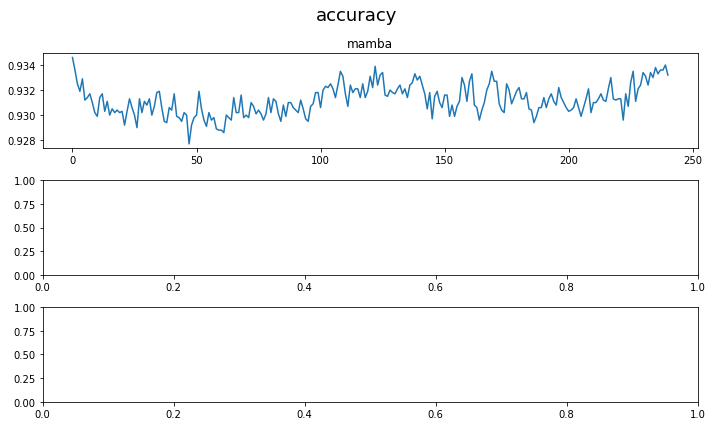

In [10]:
burnin_sgld_mamba = 10
burnin_sgld_gridsearch = 0
burnin_sgld_baseline = 0

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
ax[0].plot(accuracy_list_sgld_mamba)
ax[0].set_title("mamba")

plt.tight_layout()

print(np.mean(accuracy_list_sgld_mamba[burnin_sgld_mamba:]))

In [11]:
ood_entropy_samples_sgld_mamba = ood_testing(samples_sgld_mamba[burnin_sgld_mamba:], X_test)

np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgld_mamba.txt", ood_entropy_samples_sgld_mamba)


In [12]:
# gridsearch
ece_est, mce_est, num_samples, accuracy_list_sgld_gridsearch, samples_sgld_gridsearch = run_time_budget(
                key, time_budget, partial_build_sgld, thin, gridsearch_params)
print(f"gridsearch: {ece_est, mce_est, num_samples}")


Assessing the samples. Num samples: 16343
calculating ECE/MCE
calculating accuracy list



gridsearch: (0.1460456787109375, DeviceArray(0.42104274, dtype=float32), 16343)


0.937836


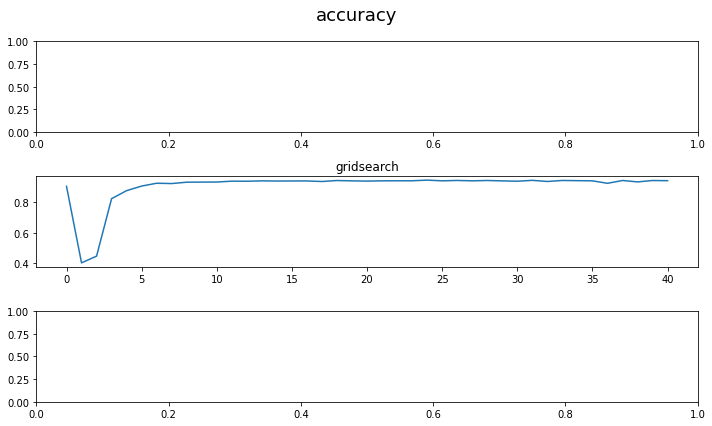

In [17]:
# burnin_sgld_mamba = 10
burnin_sgld_gridsearch = 5
# burnin_sgld_baseline = 0

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
ax[1].plot(accuracy_list_sgld_gridsearch)
ax[1].set_title("gridsearch")

plt.tight_layout()

print(np.mean(accuracy_list_sgld_gridsearch[burnin_sgld_gridsearch:]))

In [18]:
ood_entropy_samples_sgld_gridsearch = ood_testing(samples_sgld_gridsearch[burnin_sgld_gridsearch:], X_test)

np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgld_gridsearch.txt", ood_entropy_samples_sgld_gridsearch)


In [19]:

ece_est, mce_est, num_samples, accuracy_list_sgld_baseline, samples_sgld_baseline = run_time_budget(
                key, time_budget, partial_build_sgld, thin, baseline_params)
print(f"baseline: {ece_est, mce_est, num_samples}")


Assessing the samples. Num samples: 15192
calculating ECE/MCE
calculating accuracy list



baseline: (0.008206493377685547, DeviceArray(0.23328367, dtype=float32), 15192)


0.9325182


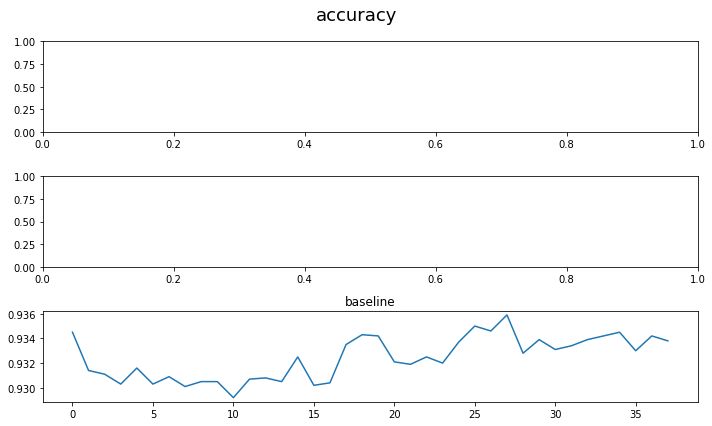

In [22]:
# burnin_sgld_mamba = 10
# burnin_sgld_gridsearch = 0
burnin_sgld_baseline = 5

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
ax[2].plot(accuracy_list_sgld_baseline)
ax[2].set_title("baseline")

plt.tight_layout()

print(np.mean(accuracy_list_sgld_baseline[burnin_sgld_baseline:]))

In [23]:

ood_entropy_samples_sgld_baseline = ood_testing(samples_sgld_baseline[burnin_sgld_baseline:], X_test)

np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgld_baseline.txt", ood_entropy_samples_sgld_baseline)



In [16]:

ood_entropy_samples_sgld_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgld_mamba.txt")
ood_entropy_samples_sgld_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgld_gridsearch.txt")
ood_entropy_samples_sgld_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgld_baseline.txt")


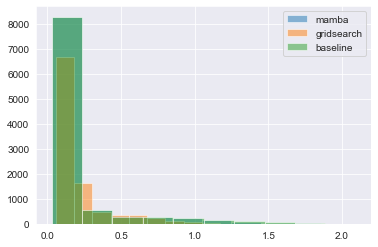

In [17]:

plt.hist(ood_entropy_samples_sgld_mamba, label='mamba', alpha=0.5)
plt.hist(ood_entropy_samples_sgld_gridsearch, label='gridsearch', alpha=0.5)
plt.hist(ood_entropy_samples_sgld_baseline, label='baseline', alpha=0.5)

plt.legend()
plt.show()


### sgld-cv


In [12]:
sh_params = {'batch_size': 600, 'dt': 3.1622776e-06}# found using both large and small batch size grids
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

print("ece_est, mce_est, num_samples:\n")
ece_est, mce_est, num_samples, accuracy_list_sgldCV_mamba, samples_sgldCV_mamba = run_time_budget(
                key, time_budget, partial_build_sgldCV, thin, sh_params)
print(f"MAMBA: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sgldCV_gridsearch, samples_sgldCV_gridsearch = run_time_budget(
#                 key, time_budget, partial_build_sgldCV, thin, gridsearch_params)
# print(f"gridsearch: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sgldCV_baseline, samples_sgldCV_baseline = run_time_budget(
#                 key, time_budget, partial_build_sgldCV, thin, baseline_params)
# print(f"baseline: {ece_est, mce_est, num_samples}")



ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 67395
calculating ECE/MCE
calculating accuracy list



MAMBA: (0.009091217041015625, DeviceArray(0.15734492, dtype=float32), 67395)


0.9310591


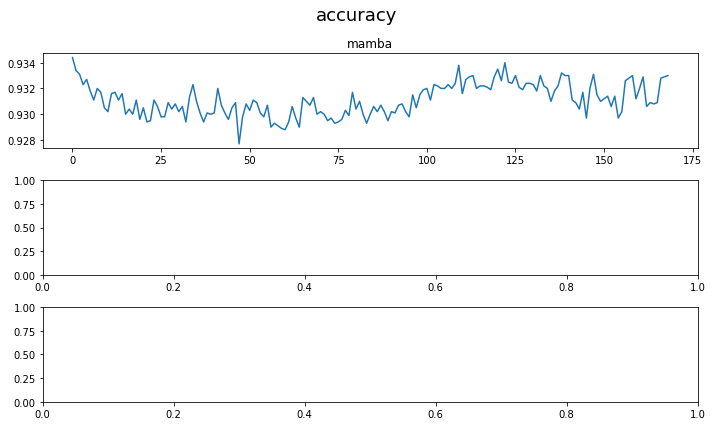

In [13]:
burnin_sgldCV_mamba = 5
burnin_sgldCV_gridsearch = 5
burnin_sgldCV_baseline = 5

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
ax[0].plot(accuracy_list_sgldCV_mamba)
ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sgldCV_gridsearch)
# ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sgldCV_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

print(np.mean(accuracy_list_sgldCV_mamba[burnin_sgldCV_mamba:]))
# print(np.mean(accuracy_list_sgldCV_gridsearch[burnin_sgldCV_gridsearch:]))
# print(np.mean(accuracy_list_sgldCV_baseline[burnin_sgldCV_baseline:]))

In [14]:
ood_entropy_samples_sgldCV_mamba = ood_testing(samples_sgldCV_mamba[burnin_sgldCV_mamba:], X_test)
# ood_entropy_samples_sgldCV_gridsearch = ood_testing(samples_sgldCV_gridsearch[burnin_sgldCV_gridsearch:], X_test)
# ood_entropy_samples_sgldCV_baseline = ood_testing(samples_sgldCV_baseline[burnin_sgldCV_baseline:], X_test)

np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_mamba.txt", ood_entropy_samples_sgldCV_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_gridsearch.txt", ood_entropy_samples_sgldCV_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_baseline.txt", ood_entropy_samples_sgldCV_baseline)


In [32]:
sh_params = {'batch_size': 600, 'dt': 3.1622776e-06}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

# print("ece_est, mce_est, num_samples:\n")
# ece_est, mce_est, num_samples, accuracy_list_sgldCV_mamba, samples_sgldCV_mamba = run_time_budget(
#                 key, time_budget, partial_build_sgldCV, thin, sh_params)
# print(f"MAMBA: {ece_est, mce_est, num_samples}")

ece_est, mce_est, num_samples, accuracy_list_sgldCV_gridsearch, samples_sgldCV_gridsearch = run_time_budget(
                key, time_budget, partial_build_sgldCV, thin, gridsearch_params)
print(f"gridsearch: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sgldCV_baseline, samples_sgldCV_baseline = run_time_budget(
#                 key, time_budget, partial_build_sgldCV, thin, baseline_params)
# print(f"baseline: {ece_est, mce_est, num_samples}")



Assessing the samples. Num samples: 9659
calculating ECE/MCE
calculating accuracy list



gridsearch: (0.088268701171875, DeviceArray(0.40650263, dtype=float32), 9659)


0.942035


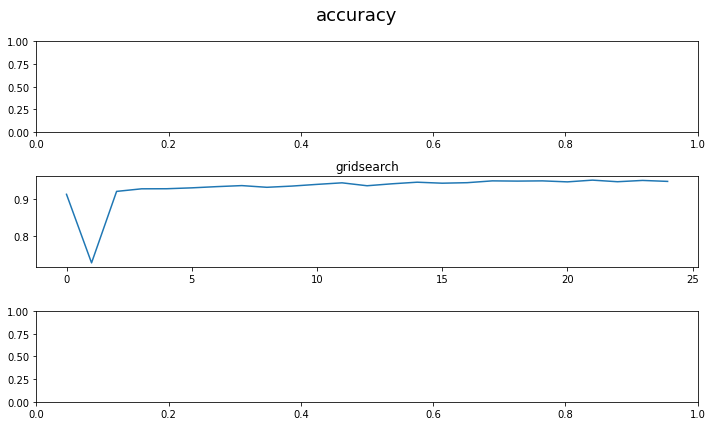

In [33]:
burnin_sgldCV_mamba = 5
burnin_sgldCV_gridsearch = 5
burnin_sgldCV_baseline = 5

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sgldCV_mamba)
# ax[0].set_title("mamba")
ax[1].plot(accuracy_list_sgldCV_gridsearch)
ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sgldCV_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sgldCV_mamba[burnin_sgldCV_mamba:]))
print(np.mean(accuracy_list_sgldCV_gridsearch[burnin_sgldCV_gridsearch:]))
# print(np.mean(accuracy_list_sgldCV_baseline[burnin_sgldCV_baseline:]))

In [34]:
# ood_entropy_samples_sgldCV_mamba = ood_testing(samples_sgldCV_mamba[burnin_sgldCV_mamba:], X_test)
ood_entropy_samples_sgldCV_gridsearch = ood_testing(samples_sgldCV_gridsearch[burnin_sgldCV_gridsearch:], X_test)
# ood_entropy_samples_sgldCV_baseline = ood_testing(samples_sgldCV_baseline[burnin_sgldCV_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_mamba.txt", ood_entropy_samples_sgldCV_mamba)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_gridsearch.txt", ood_entropy_samples_sgldCV_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_baseline.txt", ood_entropy_samples_sgldCV_baseline)


In [35]:
sh_params = {'batch_size': 600, 'dt': 3.1622776e-06}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

# print("ece_est, mce_est, num_samples:\n")
# ece_est, mce_est, num_samples, accuracy_list_sgldCV_mamba, samples_sgldCV_mamba = run_time_budget(
#                 key, time_budget, partial_build_sgldCV, thin, sh_params)
# print(f"MAMBA: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sgldCV_gridsearch, samples_sgldCV_gridsearch = run_time_budget(
#                 key, time_budget, partial_build_sgldCV, thin, gridsearch_params)
# print(f"gridsearch: {ece_est, mce_est, num_samples}")

ece_est, mce_est, num_samples, accuracy_list_sgldCV_baseline, samples_sgldCV_baseline = run_time_budget(
                key, time_budget, partial_build_sgldCV, thin, baseline_params)
print(f"baseline: {ece_est, mce_est, num_samples}")



Assessing the samples. Num samples: 9534
calculating ECE/MCE
calculating accuracy list



baseline: (0.007145311737060547, DeviceArray(0.22008447, dtype=float32), 9534)


0.93174213


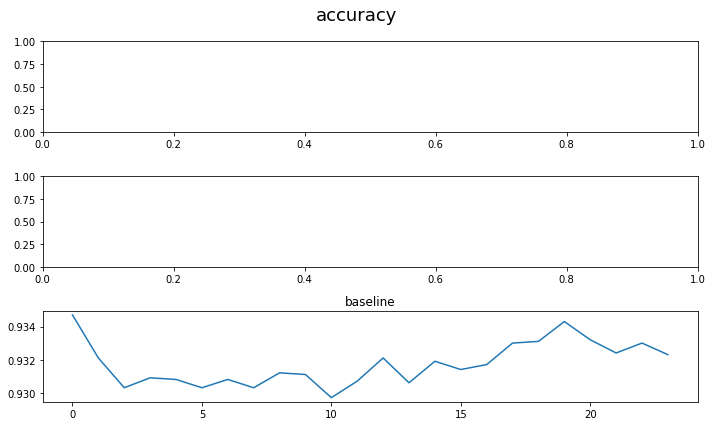

In [36]:
# burnin_sgldCV_mamba = 5
# burnin_sgldCV_gridsearch = 5
burnin_sgldCV_baseline = 5

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sgldCV_mamba)
# ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sgldCV_gridsearch)
# ax[1].set_title("gridsearch")
ax[2].plot(accuracy_list_sgldCV_baseline)
ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sgldCV_mamba[burnin_sgldCV_mamba:]))
# print(np.mean(accuracy_list_sgldCV_gridsearch[burnin_sgldCV_gridsearch:]))
print(np.mean(accuracy_list_sgldCV_baseline[burnin_sgldCV_baseline:]))


In [37]:
# ood_entropy_samples_sgldCV_mamba = ood_testing(samples_sgldCV_mamba[burnin_sgldCV_mamba:], X_test)
# ood_entropy_samples_sgldCV_gridsearch = ood_testing(samples_sgldCV_gridsearch[burnin_sgldCV_gridsearch:], X_test)
ood_entropy_samples_sgldCV_baseline = ood_testing(samples_sgldCV_baseline[burnin_sgldCV_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_mamba.txt", ood_entropy_samples_sgldCV_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_gridsearch.txt", ood_entropy_samples_sgldCV_gridsearch)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_baseline.txt", ood_entropy_samples_sgldCV_baseline)


In [56]:

# ood_entropy_samples_sgldCV_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_mamba.txt")
# ood_entropy_samples_sgldCV_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_gridsearch.txt")
# ood_entropy_samples_sgldCV_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_baseline.txt")


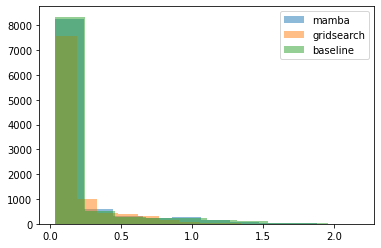

In [38]:


plt.hist(ood_entropy_samples_sgldCV_mamba, label='mamba', alpha=0.5)
plt.hist(ood_entropy_samples_sgldCV_gridsearch, label='gridsearch', alpha=0.5)
plt.hist(ood_entropy_samples_sgldCV_baseline, label='baseline', alpha=0.5)

plt.legend()
plt.show()


### sghmc



In [15]:
thin = 40

In [16]:
sh_params = {'batch_size': 600, 'L': 5, 'dt': 3.1622776e-07} # small batch size grid
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}
baseline_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}


print("ece_est, mce_est, num_samples:\n")
ece_est, mce_est, num_samples, accuracy_list_sghmc_mamba, samples_sghmc_mamba = run_time_budget(
                key, time_budget, partial_build_sghmc, thin, sh_params)
print(f"MAMBA: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sghmc_gridsearch, samples_sghmc_gridsearch = run_time_budget(
#                 key, time_budget, partial_build_sghmc, thin, gridsearch_params)
# print(f"gridsearch: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sghmc_baseline, samples_sghmc_baseline = run_time_budget(
#                 key, time_budget, partial_build_sghmc, thin, baseline_params)
# print(f"baseline: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 23671
calculating ECE/MCE
calculating accuracy list



MAMBA: (0.007094704437255859, DeviceArray(0.47106445, dtype=float32), 23671)


0.93012303


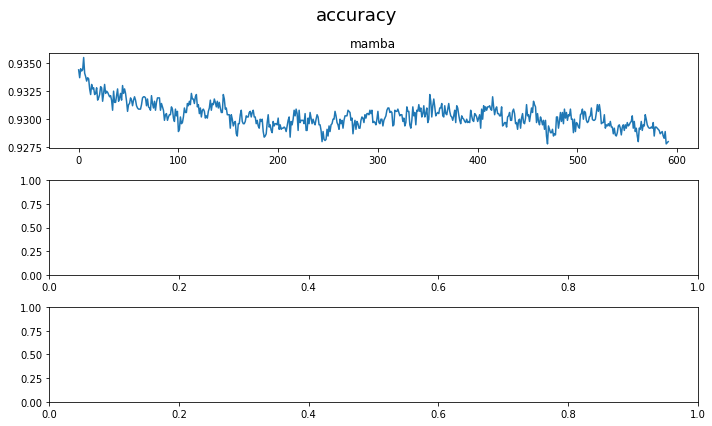

In [17]:
burnin_sghmc_mamba = 50
burnin_sghmc_gridsearch = 50
burnin_sghmc_baseline = 50

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
ax[0].plot(accuracy_list_sghmc_mamba)
ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sghmc_gridsearch)
# ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sghmc_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

print(np.mean(accuracy_list_sghmc_mamba[burnin_sghmc_mamba:]))
# print(np.mean(accuracy_list_sghmc_gridsearch[burnin_sghmc_gridsearch:]))
# print(np.mean(accuracy_list_sghmc_baseline[burnin_sghmc_baseline:]))


In [18]:
ood_entropy_samples_sghmc_mamba = ood_testing(samples_sghmc_mamba[burnin_sghmc_mamba:], X_test)
# ood_entropy_samples_sghmc_gridsearch = ood_testing(samples_sghmc_gridsearch[burnin_sghmc_gridsearch:], X_test)
# ood_entropy_samples_sghmc_baseline = ood_testing(samples_sghmc_baseline[burnin_sghmc_baseline:], X_test)

np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_mamba.txt", ood_entropy_samples_sghmc_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_gridsearch.txt", ood_entropy_samples_sghmc_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_baseline.txt", ood_entropy_samples_sghmc_baseline)



In [49]:
# gridsearch
thin = 5

sh_params = {'batch_size': 600, 'L': 5, 'dt': 3.1622776e-07}
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}
baseline_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}


print("ece_est, mce_est, num_samples:\n")
# ece_est, mce_est, num_samples, accuracy_list_sghmc_mamba, samples_sghmc_mamba = run_time_budget(
#                 key, time_budget, partial_build_sghmc, thin, sh_params)
# print(f"MAMBA: {ece_est, mce_est, num_samples}")

ece_est, mce_est, num_samples, accuracy_list_sghmc_gridsearch, samples_sghmc_gridsearch = run_time_budget(
                key, time_budget, partial_build_sghmc, thin, gridsearch_params)
print(f"gridsearch: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sghmc_baseline, samples_sghmc_baseline = run_time_budget(
#                 key, time_budget, partial_build_sghmc, thin, baseline_params)
# print(f"baseline: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 1761
calculating ECE/MCE
calculating accuracy list



gridsearch: (0.2066101806640625, DeviceArray(0.65530646, dtype=float32), 1761)


0.9246955


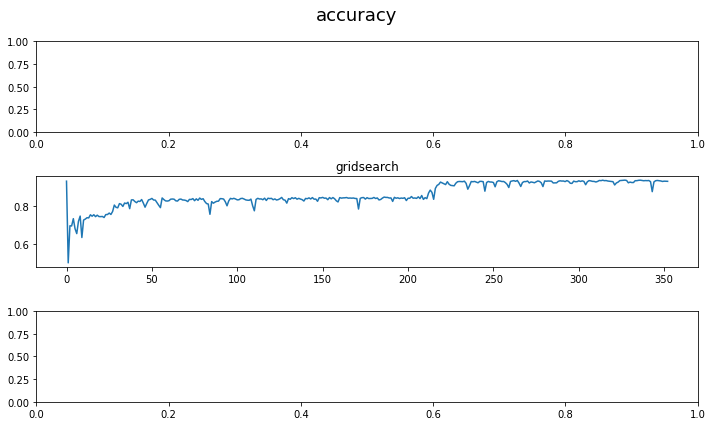

In [51]:
burnin_sghmc_mamba = 50
burnin_sghmc_gridsearch = 240
burnin_sghmc_baseline = 50

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sghmc_mamba)
# ax[0].set_title("mamba")
ax[1].plot(accuracy_list_sghmc_gridsearch)
ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sghmc_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sghmc_mamba[burnin_sghmc_mamba:]))
print(np.mean(accuracy_list_sghmc_gridsearch[burnin_sghmc_gridsearch:]))
# print(np.mean(accuracy_list_sghmc_baseline[burnin_sghmc_baseline:]))


In [52]:
# ood_entropy_samples_sghmc_mamba = ood_testing(samples_sghmc_mamba[burnin_sghmc_mamba:], X_test)
ood_entropy_samples_sghmc_gridsearch = ood_testing(samples_sghmc_gridsearch[burnin_sghmc_gridsearch:], X_test)
# ood_entropy_samples_sghmc_baseline = ood_testing(samples_sghmc_baseline[burnin_sghmc_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_mamba.txt", ood_entropy_samples_sghmc_mamba)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_gridsearch.txt", ood_entropy_samples_sghmc_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_baseline.txt", ood_entropy_samples_sghmc_baseline)


In [54]:
thin = 5
sh_params = {'batch_size': 600, 'L': 5, 'dt': 3.1622776e-07}
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}
baseline_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}


print("ece_est, mce_est, num_samples:\n")
# ece_est, mce_est, num_samples, accuracy_list_sghmc_mamba, samples_sghmc_mamba = run_time_budget(
#                 key, time_budget, partial_build_sghmc, thin, sh_params)
# print(f"MAMBA: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sghmc_gridsearch, samples_sghmc_gridsearch = run_time_budget(
#                 key, time_budget, partial_build_sghmc, thin, gridsearch_params)
# print(f"gridsearch: {ece_est, mce_est, num_samples}")

ece_est, mce_est, num_samples, accuracy_list_sghmc_baseline, samples_sghmc_baseline = run_time_budget(
                key, time_budget, partial_build_sghmc, thin, baseline_params)
print(f"baseline: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 1717
calculating ECE/MCE
calculating accuracy list



baseline: (0.5094384765625, DeviceArray(0.71638095, dtype=float32), 1717)


0.9172324


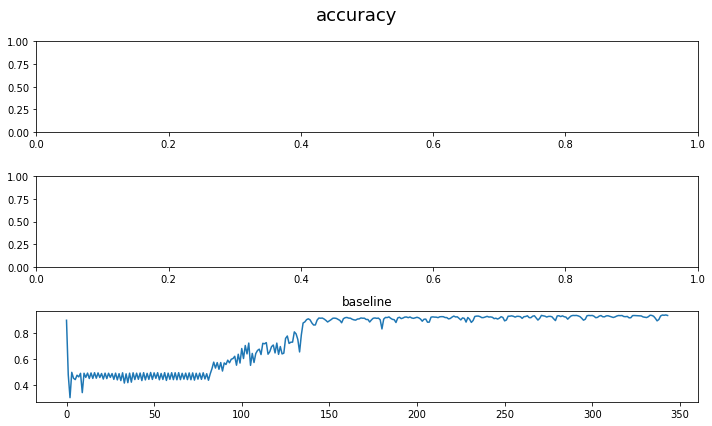

In [56]:
burnin_sghmc_mamba = 50
burnin_sghmc_gridsearch = 5
burnin_sghmc_baseline = 150

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sghmc_mamba)
# ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sghmc_gridsearch)
# ax[1].set_title("gridsearch")
ax[2].plot(accuracy_list_sghmc_baseline)
ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sghmc_mamba[burnin_sghmc_mamba:]))
# print(np.mean(accuracy_list_sghmc_gridsearch[burnin_sghmc_gridsearch:]))
print(np.mean(accuracy_list_sghmc_baseline[burnin_sghmc_baseline:]))


In [57]:
# ood_entropy_samples_sghmc_mamba = ood_testing(samples_sghmc_mamba[burnin_sghmc_mamba:], X_test)
# ood_entropy_samples_sghmc_gridsearch = ood_testing(samples_sghmc_gridsearch[burnin_sghmc_gridsearch:], X_test)
ood_entropy_samples_sghmc_baseline = ood_testing(samples_sghmc_baseline[burnin_sghmc_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_mamba.txt", ood_entropy_samples_sghmc_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_gridsearch.txt", ood_entropy_samples_sghmc_gridsearch)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_baseline.txt", ood_entropy_samples_sghmc_baseline)


In [58]:
# ood_entropy_samples_sghmc_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_mamba.txt")
# ood_entropy_samples_sghmc_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_gridsearch.txt")
# ood_entropy_samples_sghmc_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_baseline.txt")


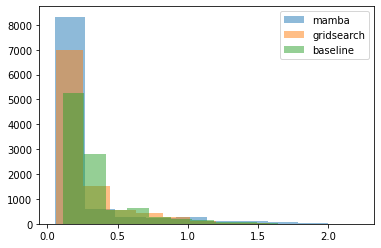

In [60]:


plt.hist(ood_entropy_samples_sghmc_mamba, label='mamba', alpha=0.5)
plt.hist(ood_entropy_samples_sghmc_gridsearch, label='gridsearch', alpha=0.5)
plt.hist(ood_entropy_samples_sghmc_baseline, label='baseline', alpha=0.5)

plt.legend()
plt.show()


### sghmc-cv



In [19]:
thin = 200

In [20]:
sh_params = {'batch_size': 600, 'L': 5, 'dt': 1e-06} # small batch size grid

print("ece_est, mce_est, num_samples:\n")
ece_est, mce_est, num_samples, accuracy_list_sghmcCV_mamba, samples_sghmcCV_mamba = run_time_budget(
                key, time_budget, partial_build_sghmcCV, thin, sh_params)
print(f"MAMBA: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 15327
calculating ECE/MCE
calculating accuracy list



MAMBA: (0.006742069244384766, DeviceArray(0.21314515, dtype=float32), 15327)


In [21]:
# gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}
# baseline_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}

# print("ece_est, mce_est, num_samples:\n")
# ece_est, mce_est, num_samples, accuracy_list_sghmcCV_mamba, samples_sghmcCV_mamba = run_time_budget(
#                 key, time_budget, partial_build_sghmcCV, thin, sh_params)
# print(f"MAMBA: {ece_est, mce_est, num_samples}")



0.93129474


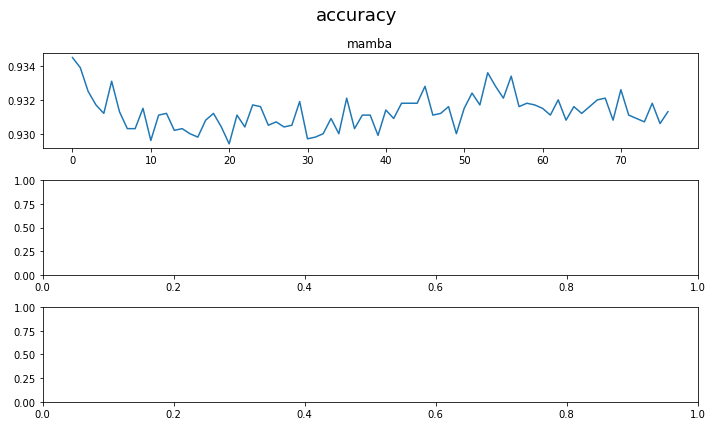

In [22]:
burnin_sghmcCV_mamba = 20
burnin_sghmcCV_gridsearch = 5
burnin_sghmcCV_baseline = 5

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
ax[0].plot(accuracy_list_sghmcCV_mamba)
ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sghmcCV_gridsearch)
# ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sghmcCV_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

print(np.mean(accuracy_list_sghmcCV_mamba[burnin_sghmcCV_mamba:]))
# print(np.mean(accuracy_list_sghmcCV_gridsearch[burnin_sghmcCV_gridsearch:]))
# print(np.mean(accuracy_list_sghmcCV_baseline[burnin_sghmcCV_baseline:]))


In [23]:
ood_entropy_samples_sghmcCV_mamba = ood_testing(samples_sghmcCV_mamba[burnin_sghmcCV_mamba:], X_test)
# ood_entropy_samples_sghmcCV_gridsearch = ood_testing(samples_sghmcCV_gridsearch[burnin_sghmcCV_gridsearch:], X_test)
# ood_entropy_samples_sghmcCV_baseline = ood_testing(samples_sghmcCV_baseline[burnin_sghmcCV_baseline:], X_test)

np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_mamba.txt", ood_entropy_samples_sghmcCV_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_gridsearch.txt", ood_entropy_samples_sghmcCV_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_baseline.txt", ood_entropy_samples_sghmcCV_baseline)


In [78]:
# gridsearch
thin = 3
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}

print("ece_est, mce_est, num_samples:\n")
# ece_est, mce_est, num_samples, accuracy_list_sghmcCV_mamba, samples_sghmcCV_mamba = run_time_budget(
#                 key, time_budget, partial_build_sghmcCV, thin, sh_params)
# print(f"MAMBA: {ece_est, mce_est, num_samples}")

ece_est, mce_est, num_samples, accuracy_list_sghmcCV_gridsearch, samples_sghmcCV_gridsearch = run_time_budget(
                key, time_budget, partial_build_sghmcCV, thin, gridsearch_params)
print(f"gridsearch: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sghmcCV_baseline, samples_sghmcCV_baseline = run_time_budget(
#                 key, time_budget, partial_build_sghmcCV, thin, baseline_params)
# print(f"baseline: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 1013
calculating ECE/MCE
calculating accuracy list



gridsearch: (0.2515013671875, DeviceArray(0.5520834, dtype=float32), 1013)


0.828642


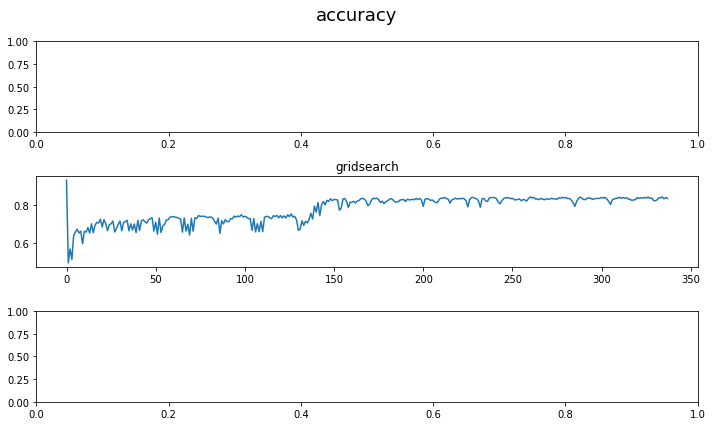

In [86]:
burnin_sghmcCV_mamba = 5
burnin_sghmcCV_gridsearch = 150
burnin_sghmcCV_baseline = 5

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sghmcCV_mamba)
# ax[0].set_title("mamba")
ax[1].plot(accuracy_list_sghmcCV_gridsearch)
ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sghmcCV_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sghmcCV_mamba[burnin_sghmcCV_mamba:]))
print(np.mean(accuracy_list_sghmcCV_gridsearch[burnin_sghmcCV_gridsearch:]))
# print(np.mean(accuracy_list_sghmcCV_baseline[burnin_sghmcCV_baseline:]))


In [87]:
# ood_entropy_samples_sghmcCV_mamba = ood_testing(samples_sghmcCV_mamba[burnin_sghmcCV_mamba:], X_test)
ood_entropy_samples_sghmcCV_gridsearch = ood_testing(samples_sghmcCV_gridsearch[burnin_sghmcCV_gridsearch:], X_test)
# ood_entropy_samples_sghmcCV_baseline = ood_testing(samples_sghmcCV_baseline[burnin_sghmcCV_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_mamba.txt", ood_entropy_samples_sghmcCV_mamba)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_gridsearch.txt", ood_entropy_samples_sghmcCV_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_baseline.txt", ood_entropy_samples_sghmcCV_baseline)


In [81]:
thin = 5
baseline_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}

print("ece_est, mce_est, num_samples:\n")
# ece_est, mce_est, num_samples, accuracy_list_sghmcCV_mamba, samples_sghmcCV_mamba = run_time_budget(
#                 key, time_budget, partial_build_sghmcCV, thin, sh_params)
# print(f"MAMBA: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sghmcCV_gridsearch, samples_sghmcCV_gridsearch = run_time_budget(
#                 key, time_budget, partial_build_sghmcCV, thin, gridsearch_params)
# print(f"gridsearch: {ece_est, mce_est, num_samples}")

ece_est, mce_est, num_samples, accuracy_list_sghmcCV_baseline, samples_sghmcCV_baseline = run_time_budget(
                key, time_budget, partial_build_sghmcCV, thin, baseline_params)
print(f"baseline: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 984
calculating ECE/MCE
calculating accuracy list



baseline: (0.4078271484375, DeviceArray(0.74838185, dtype=float32), 984)


0.90065366


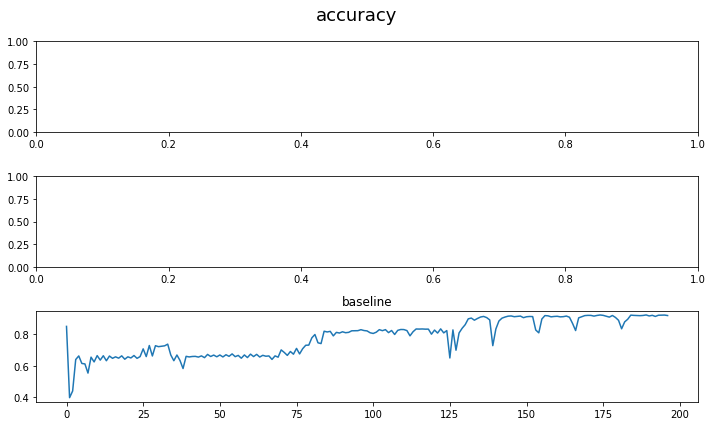

In [84]:
burnin_sghmcCV_mamba = 5
burnin_sghmcCV_gridsearch = 5
burnin_sghmcCV_baseline = 130

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sghmcCV_mamba)
# ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sghmcCV_gridsearch)
# ax[1].set_title("gridsearch")
ax[2].plot(accuracy_list_sghmcCV_baseline)
ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sghmcCV_mamba[burnin_sghmcCV_mamba:]))
# print(np.mean(accuracy_list_sghmcCV_gridsearch[burnin_sghmcCV_gridsearch:]))
print(np.mean(accuracy_list_sghmcCV_baseline[burnin_sghmcCV_baseline:]))


In [85]:
# ood_entropy_samples_sghmcCV_mamba = ood_testing(samples_sghmcCV_mamba[burnin_sghmcCV_mamba:], X_test)
# ood_entropy_samples_sghmcCV_gridsearch = ood_testing(samples_sghmcCV_gridsearch[burnin_sghmcCV_gridsearch:], X_test)
ood_entropy_samples_sghmcCV_baseline = ood_testing(samples_sghmcCV_baseline[burnin_sghmcCV_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_mamba.txt", ood_entropy_samples_sghmcCV_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_gridsearch.txt", ood_entropy_samples_sghmcCV_gridsearch)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_baseline.txt", ood_entropy_samples_sghmcCV_baseline)


In [91]:

# ood_entropy_samples_sghmcCV_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_mamba.txt")
# ood_entropy_samples_sghmcCV_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_gridsearch.txt")
# ood_entropy_samples_sghmcCV_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_baseline.txt")


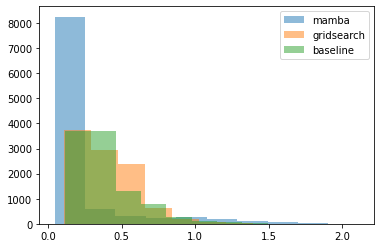

In [90]:


plt.hist(ood_entropy_samples_sghmcCV_mamba, label='mamba', alpha=0.5)
plt.hist(ood_entropy_samples_sghmcCV_gridsearch, label='gridsearch', alpha=0.5)
plt.hist(ood_entropy_samples_sghmcCV_baseline, label='baseline', alpha=0.5)

plt.legend()
plt.show()


### sgnht

ece_est, mce_est, num_samples:




In [11]:
# print({'batch_size': 600, 'dt': 3.1622778e-05})
print({'batch_size': 600, 'dt': 1e-05})
print({'batch_size': gridsearch_bs, 'dt': 1e-5})
print({'batch_size': gridsearch_bs, 'dt': dt_baseline})


{'batch_size': 600, 'dt': 1e-05}
{'batch_size': 6000, 'dt': 1e-05}
{'batch_size': 6000, 'dt': 1.6666666666666667e-05}


In [34]:
np.log10(3.1622778e-05)

-4.499999980796089

In [ ]:
# def _run_time_budget(key, time_budget, build_kernel, thin, dict_params, params_IC=load_NN_MAP()):
#     timed_sampler_factory = timed_sampler(build_kernel)
#     my_timed_sampler = timed_sampler_factory(**dict_params)
#     samples, grads = my_timed_sampler(key, time_budget, params_IC)
#     return samples, grads

# thin = 400
# sh_params = {'batch_size': 600, 'dt': 3.1622778e-05} # small batch size grid

# # time_budget = 300
# time_budget = 12

# mysams, mygrads = _run_time_budget(random.split(key, 5)[4], time_budget, partial_build_sgnht, thin, sh_params)

In [ ]:
# fl_sams = flatten_param_list(mysams[::200])
# plt.plot(fl_sams[:,-5])

# get_ECE_MCE(fl_sams, X_test, y_test, M=10, pbar=False)

In [6]:
thin = 400
sh_params = {'batch_size': 600, 'dt': 1e-05} # small batch size grid

print("ece_est, mce_est, num_samples:\n")
ece_est, mce_est, num_samples, accuracy_list_sgnht_mamba, samples_sgnht_mamba = run_time_budget(
                key, time_budget, partial_build_sgnht, thin, sh_params)
print(f"MAMBA: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sgnht_gridsearch, samples_sgnht_gridsearch = run_time_budget(
#                 key, time_budget, partial_build_sgnht, thin, gridsearch_params)
# print(f"gridsearch: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sgnht_baseline, samples_sgnht_baseline = run_time_budget(
#                 key, time_budget, partial_build_sgnht, thin, baseline_params)
# print(f"baseline: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 88021
calculating ECE/MCE
calculating accuracy list



MAMBA: (0.09329671020507813, DeviceArray(0.45651722, dtype=float32), 88021)


0.93986964


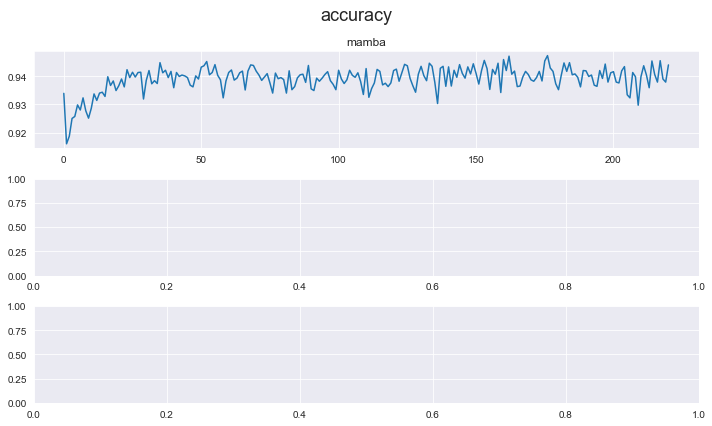

In [10]:
burnin_sgnht_mamba = 20
burnin_sgnht_gridsearch = 5
burnin_sgnht_baseline = 5

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
ax[0].plot(accuracy_list_sgnht_mamba)
ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sgnht_gridsearch)
# ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sgnht_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

print(np.mean(accuracy_list_sgnht_mamba[burnin_sgnht_mamba:]))
# print(np.mean(accuracy_list_sgnht_gridsearch[burnin_sgnht_gridsearch:]))
# print(np.mean(accuracy_list_sgnht_baseline[burnin_sgnht_baseline:]))


In [8]:
ood_entropy_samples_sgnht_mamba = ood_testing(samples_sgnht_mamba[burnin_sgnht_mamba:], X_test)
# ood_entropy_samples_sgnht_gridsearch = ood_testing(samples_sgnht_gridsearch[burnin_sgnht_gridsearch:], X_test)
# ood_entropy_samples_sgnht_baseline = ood_testing(samples_sgnht_baseline[burnin_sgnht_baseline:], X_test)

np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_mamba.txt", ood_entropy_samples_sgnht_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_gridsearch.txt", ood_entropy_samples_sgnht_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_baseline.txt", ood_entropy_samples_sgnht_baseline)


In [12]:
thin = 100
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 1e-5}

# print("ece_est, mce_est, num_samples:\n")
# ece_est, mce_est, num_samples, accuracy_list_sgnht_mamba, samples_sgnht_mamba = run_time_budget(
#                 key, time_budget, partial_build_sgnht, thin, sh_params)
# print(f"MAMBA: {ece_est, mce_est, num_samples}")

ece_est, mce_est, num_samples, accuracy_list_sgnht_gridsearch, samples_sgnht_gridsearch = run_time_budget(
                key, time_budget, partial_build_sgnht, thin, gridsearch_params)
print(f"gridsearch: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sgnht_baseline, samples_sgnht_baseline = run_time_budget(
#                 key, time_budget, partial_build_sgnht, thin, baseline_params)
# print(f"baseline: {ece_est, mce_est, num_samples}")


Assessing the samples. Num samples: 17062
calculating ECE/MCE
calculating accuracy list



gridsearch: (0.054248046875, DeviceArray(0.4224635, dtype=float32), 17062)


0.9510091


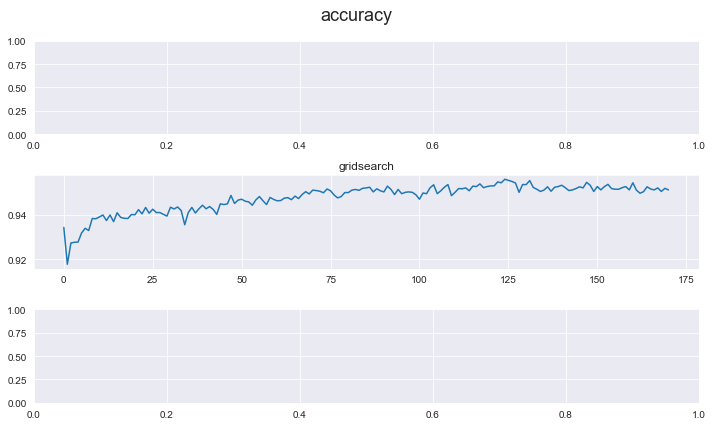

In [15]:
burnin_sgnht_gridsearch = 50

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sgnht_mamba)
# ax[0].set_title("mamba")
ax[1].plot(accuracy_list_sgnht_gridsearch)
ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sgnht_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sgnht_mamba[burnin_sgnht_mamba:]))
print(np.mean(accuracy_list_sgnht_gridsearch[burnin_sgnht_gridsearch:]))
# print(np.mean(accuracy_list_sgnht_baseline[burnin_sgnht_baseline:]))


In [16]:
# ood_entropy_samples_sgnht_mamba = ood_testing(samples_sgnht_mamba[burnin_sgnht_mamba:], X_test)
ood_entropy_samples_sgnht_gridsearch = ood_testing(samples_sgnht_gridsearch[burnin_sgnht_gridsearch:], X_test)
# ood_entropy_samples_sgnht_baseline = ood_testing(samples_sgnht_baseline[burnin_sgnht_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_mamba.txt", ood_entropy_samples_sgnht_mamba)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_gridsearch.txt", ood_entropy_samples_sgnht_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_baseline.txt", ood_entropy_samples_sgnht_baseline)


In [9]:
thin = 100
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

# print("ece_est, mce_est, num_samples:\n")
# ece_est, mce_est, num_samples, accuracy_list_sgnht_mamba, samples_sgnht_mamba = run_time_budget(
#                 key, time_budget, partial_build_sgnht, thin, sh_params)
# print(f"MAMBA: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sgnht_gridsearch, samples_sgnht_gridsearch = run_time_budget(
#                 key, time_budget, partial_build_sgnht, thin, gridsearch_params)
# print(f"gridsearch: {ece_est, mce_est, num_samples}")

ece_est, mce_est, num_samples, accuracy_list_sgnht_baseline, samples_sgnht_baseline = run_time_budget(
                key, time_budget, partial_build_sgnht, thin, baseline_params)
print(f"baseline: {ece_est, mce_est, num_samples}")


Assessing the samples. Num samples: 16727
calculating ECE/MCE
calculating accuracy list



baseline: (0.062427630615234375, DeviceArray(0.43218303, dtype=float32), 16727)


0.9524306


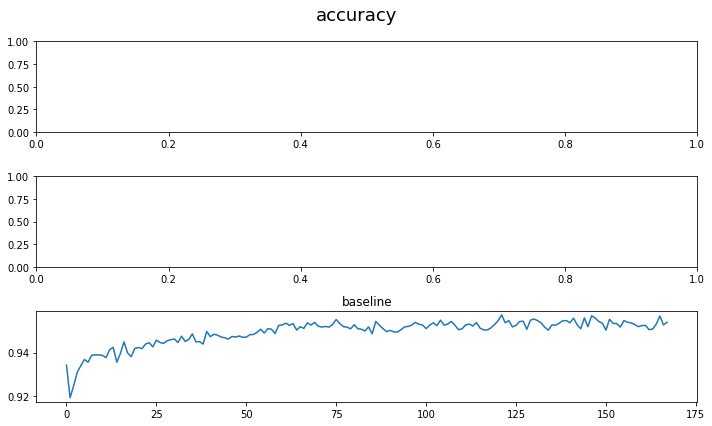

In [12]:
burnin_sgnht_baseline = 50

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sgnht_mamba)
# ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sgnht_gridsearch)
# ax[1].set_title("gridsearch")
ax[2].plot(accuracy_list_sgnht_baseline)
ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sgnht_mamba[burnin_sgnht_mamba:]))
# print(np.mean(accuracy_list_sgnht_gridsearch[burnin_sgnht_gridsearch:]))
print(np.mean(accuracy_list_sgnht_baseline[burnin_sgnht_baseline:]))


In [13]:
# ood_entropy_samples_sgnht_mamba = ood_testing(samples_sgnht_mamba[burnin_sgnht_mamba:], X_test)
# ood_entropy_samples_sgnht_gridsearch = ood_testing(samples_sgnht_gridsearch[burnin_sgnht_gridsearch:], X_test)
ood_entropy_samples_sgnht_baseline = ood_testing(samples_sgnht_baseline[burnin_sgnht_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_mamba.txt", ood_entropy_samples_sgnht_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_gridsearch.txt", ood_entropy_samples_sgnht_gridsearch)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_baseline.txt", ood_entropy_samples_sgnht_baseline)


In [14]:

# ood_entropy_samples_sgnht_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_mamba.txt")
# ood_entropy_samples_sgnht_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_gridsearch.txt")
# ood_entropy_samples_sgnht_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_baseline.txt")


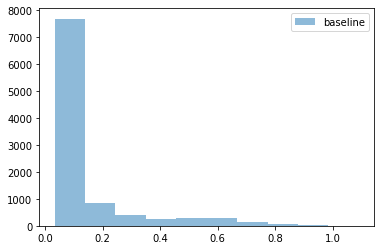

In [18]:


# plt.hist(ood_entropy_samples_sgnht_mamba, label='mamba', alpha=0.5)
# plt.hist(ood_entropy_samples_sgnht_gridsearch, label='gridsearch', alpha=0.5)
plt.hist(ood_entropy_samples_sgnht_baseline, label='baseline', alpha=0.5)

plt.legend()
plt.show()


### sgnht-cv



In [27]:
thin = 100
sh_params = {'batch_size': 600, 'dt': 3.1622776e-08} # small batch size grid

print("ece_est, mce_est, num_samples:\n")
ece_est, mce_est, num_samples, accuracy_list_sgnhtCV_mamba, samples_sgnhtCV_mamba = run_time_budget(
                key, time_budget, partial_build_sgnhtCV, thin, sh_params)
print(f"MAMBA: {ece_est, mce_est, num_samples}")



ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 62389
calculating ECE/MCE
calculating accuracy list



MAMBA: (0.008694817352294921, DeviceArray(0.27414736, dtype=float32), 62389)


0.9307381


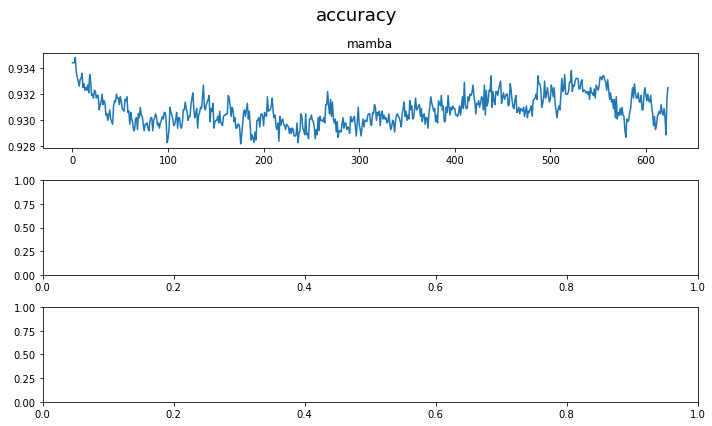

In [28]:
burnin_sgnhtCV_mamba = 50

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
ax[0].plot(accuracy_list_sgnhtCV_mamba)
ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sgnhtCV_gridsearch)
# ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sgnhtCV_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

print(np.mean(accuracy_list_sgnhtCV_mamba[burnin_sgnhtCV_mamba:]))
# print(np.mean(accuracy_list_sgnhtCV_gridsearch[burnin_sgnhtCV_gridsearch:]))
# print(np.mean(accuracy_list_sgnhtCV_baseline[burnin_sgnhtCV_baseline:]))


In [29]:
ood_entropy_samples_sgnhtCV_mamba = ood_testing(samples_sgnhtCV_mamba[burnin_sgnhtCV_mamba:], X_test)

np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_mamba.txt", ood_entropy_samples_sgnhtCV_mamba)


In [37]:
# gridsearch

thin = 20
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 3.1622778e-05}

print("ece_est, mce_est, num_samples:\n")
ece_est, mce_est, num_samples, accuracy_list_sgnhtCV_gridsearch, samples_sgnhtCV_gridsearch = run_time_budget(
                key, time_budget, partial_build_sgnhtCV, thin, gridsearch_params)
print(f"gridsearch: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 9372
calculating ECE/MCE
calculating accuracy list



gridsearch: (0.07727735595703125, DeviceArray(0.4239751, dtype=float32), 9372)


0.94647706


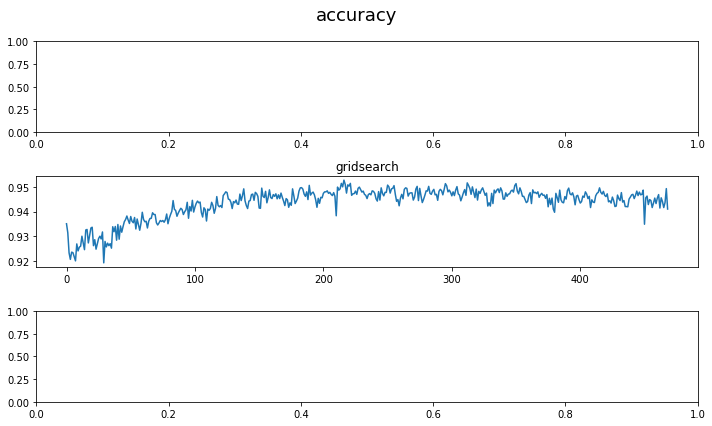

In [43]:

burnin_sgnhtCV_gridsearch = 150

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
ax[1].plot(accuracy_list_sgnhtCV_gridsearch)
ax[1].set_title("gridsearch")

plt.tight_layout()
print(np.mean(accuracy_list_sgnhtCV_gridsearch[burnin_sgnhtCV_gridsearch:]))


In [44]:
# ood_entropy_samples_sgnhtCV_mamba = ood_testing(samples_sgnhtCV_mamba[burnin_sgnhtCV_mamba:], X_test)
ood_entropy_samples_sgnhtCV_gridsearch = ood_testing(samples_sgnhtCV_gridsearch[burnin_sgnhtCV_gridsearch:], X_test)
# ood_entropy_samples_sgnhtCV_baseline = ood_testing(samples_sgnhtCV_baseline[burnin_sgnhtCV_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_mamba.txt", ood_entropy_samples_sgnhtCV_mamba)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_gridsearch.txt", ood_entropy_samples_sgnhtCV_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_baseline.txt", ood_entropy_samples_sgnhtCV_baseline)


In [40]:
thin = 20
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

print("ece_est, mce_est, num_samples:\n")

ece_est, mce_est, num_samples, accuracy_list_sgnhtCV_baseline, samples_sgnhtCV_baseline = run_time_budget(
                key, time_budget, partial_build_sgnhtCV, thin, baseline_params)
print(f"baseline: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 9382
calculating ECE/MCE
calculating accuracy list



baseline: (0.06987108154296875, DeviceArray(0.51542866, dtype=float32), 9382)


0.9498266


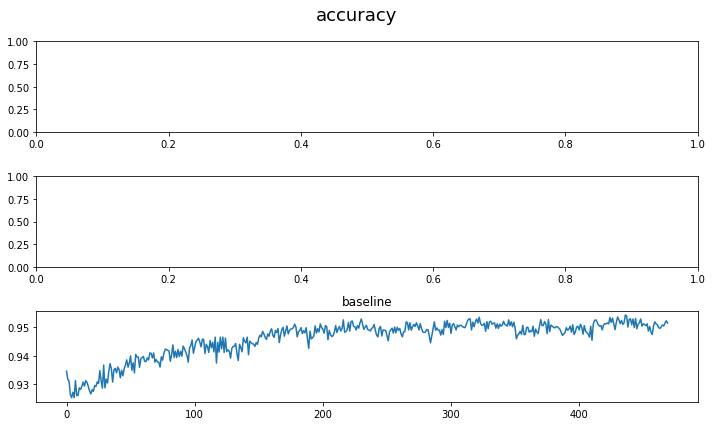

In [45]:
burnin_sgnhtCV_baseline = 200

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sgnhtCV_mamba)
# ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sgnhtCV_gridsearch)
# ax[1].set_title("gridsearch")
ax[2].plot(accuracy_list_sgnhtCV_baseline)
ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sgnhtCV_mamba[burnin_sgnhtCV_mamba:]))
# print(np.mean(accuracy_list_sgnhtCV_gridsearch[burnin_sgnhtCV_gridsearch:]))
print(np.mean(accuracy_list_sgnhtCV_baseline[burnin_sgnhtCV_baseline:]))


In [46]:
# ood_entropy_samples_sgnhtCV_mamba = ood_testing(samples_sgnhtCV_mamba[burnin_sgnhtCV_mamba:], X_test)
# ood_entropy_samples_sgnhtCV_gridsearch = ood_testing(samples_sgnhtCV_gridsearch[burnin_sgnhtCV_gridsearch:], X_test)
ood_entropy_samples_sgnhtCV_baseline = ood_testing(samples_sgnhtCV_baseline[burnin_sgnhtCV_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_mamba.txt", ood_entropy_samples_sgnhtCV_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_gridsearch.txt", ood_entropy_samples_sgnhtCV_gridsearch)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_baseline.txt", ood_entropy_samples_sgnhtCV_baseline)


In [20]:

# ood_entropy_samples_sgnhtCV_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_mamba.txt")
# ood_entropy_samples_sgnhtCV_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_gridsearch.txt")
# ood_entropy_samples_sgnhtCV_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_baseline.txt")


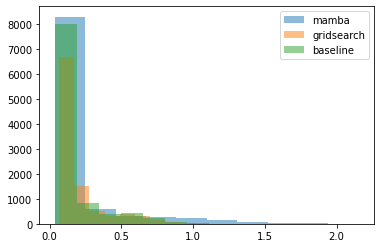

In [32]:


plt.hist(ood_entropy_samples_sgnhtCV_mamba, label='mamba', alpha=0.5)
plt.hist(ood_entropy_samples_sgnhtCV_gridsearch, label='gridsearch', alpha=0.5)
plt.hist(ood_entropy_samples_sgnhtCV_baseline, label='baseline', alpha=0.5)

plt.legend()
plt.show()


# 2. ECE curves

### sgld

In [17]:
# error_fn_ksd_curve = partial(get_ksd_NN, thin_step=20)
error_fn_ksd_curve = partial(get_ECE_NN, thin_step=20)

list_time_budget = [2, 4, 6, 8, 10]

num_curves = 5

In [38]:
dict_params = {'batch_size': 600, 'dt': 3.1622776e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 600, 'dt': 3.1622776e-06}

Iteration 0/5
Budget: 2, num_samples = 876
calculating ECE/MCE
Budget: 4, num_samples = 1508
calculating ECE/MCE
Budget: 6, num_samples = 2360
calculating ECE/MCE
Budget: 8, num_samples = 2999
calculating ECE/MCE
Budget: 10, num_samples = 3848
calculating ECE/MCE

Iteration 1/5
Budget: 2, num_samples = 851
calculating ECE/MCE
Budget: 4, num_samples = 1386
calculating ECE/MCE
Budget: 6, num_samples = 2186
calculating ECE/MCE
Budget: 8, num_samples = 3119
calculating ECE/MCE
Budget: 10, num_samples = 3918
calculating ECE/MCE

Iteration 2/5
Budget: 2, num_samples = 866
calculating ECE/MCE
Budget: 4, num_samples = 1414
calculating ECE/MCE
Budget: 6, num_samples = 2264
calculating ECE/MCE
Budget: 8, num_samples = 3063
calculating ECE/MCE
Budget: 10, num_samples = 3599
calculating ECE/MCE

Iteration 3/5
Budget: 2, num_samples = 914
calculating ECE/MCE
Budget: 4, num_samples = 1472
calculating ECE/MCE
Budget: 6, num_samples = 2471
calculat

In [39]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 0.00031622776}

Iteration 0/5
Budget: 2, num_samples = 125
calculating ECE/MCE
Budget: 4, num_samples = 210
calculating ECE/MCE
Budget: 6, num_samples = 338
calculating ECE/MCE
Budget: 8, num_samples = 439
calculating ECE/MCE
Budget: 10, num_samples = 544
calculating ECE/MCE

Iteration 1/5
Budget: 2, num_samples = 126
calculating ECE/MCE
Budget: 4, num_samples = 242
calculating ECE/MCE
Budget: 6, num_samples = 340
calculating ECE/MCE
Budget: 8, num_samples = 413
calculating ECE/MCE
Budget: 10, num_samples = 417
calculating ECE/MCE

Iteration 2/5
Budget: 2, num_samples = 72
calculating ECE/MCE
Budget: 4, num_samples = 233
calculating ECE/MCE
Budget: 6, num_samples = 349
calculating ECE/MCE
Budget: 8, num_samples = 444
calculating ECE/MCE
Budget: 10, num_samples = 558
calculating ECE/MCE

Iteration 3/5
Budget: 2, num_samples = 119
calculating ECE/MCE
Budget: 4, num_samples = 223
calculating ECE/MCE
Budget: 6, num_samples = 326
calculating ECE/MCE
Bu

In [40]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_baseline, sd_ksd_curve_sgld_baseline = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 1.6666666666666667e-05}

Iteration 0/5
Budget: 2, num_samples = 129
calculating ECE/MCE
Budget: 4, num_samples = 240
calculating ECE/MCE
Budget: 6, num_samples = 326
calculating ECE/MCE
Budget: 8, num_samples = 439
calculating ECE/MCE
Budget: 10, num_samples = 527
calculating ECE/MCE

Iteration 1/5
Budget: 2, num_samples = 118
calculating ECE/MCE
Budget: 4, num_samples = 228
calculating ECE/MCE
Budget: 6, num_samples = 254
calculating ECE/MCE
Budget: 8, num_samples = 408
calculating ECE/MCE
Budget: 10, num_samples = 454
calculating ECE/MCE

Iteration 2/5
Budget: 2, num_samples = 114
calculating ECE/MCE
Budget: 4, num_samples = 215
calculating ECE/MCE
Budget: 6, num_samples = 321
calculating ECE/MCE
Budget: 8, num_samples = 405
calculating ECE/MCE
Budget: 10, num_samples = 486
calculating ECE/MCE

Iteration 3/5
Budget: 2, num_samples = 120
calculating ECE/MCE
Budget: 4, num_samples = 224
calculating ECE/MCE
Budget: 6, num_samples = 337
calculating 

### sgld-cv

In [41]:
dict_params = {'batch_size': 600, 'dt': 3.1622776e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 600, 'dt': 3.1622776e-06}

Iteration 0/5
Budget: 2, num_samples = 563
calculating ECE/MCE
Budget: 4, num_samples = 1043
calculating ECE/MCE
Budget: 6, num_samples = 1457
calculating ECE/MCE
Budget: 8, num_samples = 1775
calculating ECE/MCE
Budget: 10, num_samples = 2251
calculating ECE/MCE

Iteration 1/5
Budget: 2, num_samples = 527
calculating ECE/MCE
Budget: 4, num_samples = 935
calculating ECE/MCE
Budget: 6, num_samples = 1293
calculating ECE/MCE
Budget: 8, num_samples = 1705
calculating ECE/MCE
Budget: 10, num_samples = 2396
calculating ECE/MCE

Iteration 2/5
Budget: 2, num_samples = 583
calculating ECE/MCE
Budget: 4, num_samples = 1092
calculating ECE/MCE
Budget: 6, num_samples = 1532
calculating ECE/MCE
Budget: 8, num_samples = 2067
calculating ECE/MCE
Budget: 10, num_samples = 2567
calculating ECE/MCE

Iteration 3/5
Budget: 2, num_samples = 584
calculating ECE/MCE
Budget: 4, num_samples = 1109
calculating ECE/MCE
Budget: 6, num_samples = 1594
calculati

In [42]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 0.00031622776}

Iteration 0/5
Budget: 2, num_samples = 76
calculating ECE/MCE
Budget: 4, num_samples = 136
calculating ECE/MCE
Budget: 6, num_samples = 189
calculating ECE/MCE
Budget: 8, num_samples = 266
calculating ECE/MCE
Budget: 10, num_samples = 315
calculating ECE/MCE

Iteration 1/5
Budget: 2, num_samples = 66
calculating ECE/MCE
Budget: 4, num_samples = 135
calculating ECE/MCE
Budget: 6, num_samples = 199
calculating ECE/MCE
Budget: 8, num_samples = 263
calculating ECE/MCE
Budget: 10, num_samples = 247
calculating ECE/MCE

Iteration 2/5
Budget: 2, num_samples = 62
calculating ECE/MCE
Budget: 4, num_samples = 137
calculating ECE/MCE
Budget: 6, num_samples = 199
calculating ECE/MCE
Budget: 8, num_samples = 261
calculating ECE/MCE
Budget: 10, num_samples = 260
calculating ECE/MCE

Iteration 3/5
Budget: 2, num_samples = 70
calculating ECE/MCE
Budget: 4, num_samples = 127
calculating ECE/MCE
Budget: 6, num_samples = 162
calculating ECE/MCE
Budge

In [43]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_baseline, sd_ksd_curve_sgldCV_baseline = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 1.6666666666666667e-05}

Iteration 0/5
Budget: 2, num_samples = 77
calculating ECE/MCE
Budget: 4, num_samples = 150
calculating ECE/MCE
Budget: 6, num_samples = 210
calculating ECE/MCE
Budget: 8, num_samples = 262
calculating ECE/MCE
Budget: 10, num_samples = 315
calculating ECE/MCE

Iteration 1/5
Budget: 2, num_samples = 66
calculating ECE/MCE
Budget: 4, num_samples = 138
calculating ECE/MCE
Budget: 6, num_samples = 191
calculating ECE/MCE
Budget: 8, num_samples = 262
calculating ECE/MCE
Budget: 10, num_samples = 335
calculating ECE/MCE

Iteration 2/5
Budget: 2, num_samples = 65
calculating ECE/MCE
Budget: 4, num_samples = 137
calculating ECE/MCE
Budget: 6, num_samples = 202
calculating ECE/MCE
Budget: 8, num_samples = 257
calculating ECE/MCE
Budget: 10, num_samples = 328
calculating ECE/MCE

Iteration 3/5
Budget: 2, num_samples = 62
calculating ECE/MCE
Budget: 4, num_samples = 127
calculating ECE/MCE
Budget: 6, num_samples = 185
calculating ECE/

### sghmc

In [44]:
dict_params = {'batch_size': 600, 'L': 5, 'dt': 3.1622776e-07}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 600, 'L': 5, 'dt': 3.1622776e-07}

Iteration 0/5
Budget: 2, num_samples = 189
calculating ECE/MCE
Budget: 4, num_samples = 372
calculating ECE/MCE
Budget: 6, num_samples = 501
calculating ECE/MCE
Budget: 8, num_samples = 614
calculating ECE/MCE
Budget: 10, num_samples = 590
calculating ECE/MCE

Iteration 1/5
Budget: 2, num_samples = 159
calculating ECE/MCE
Budget: 4, num_samples = 344
calculating ECE/MCE
Budget: 6, num_samples = 463
calculating ECE/MCE
Budget: 8, num_samples = 606
calculating ECE/MCE
Budget: 10, num_samples = 747
calculating ECE/MCE

Iteration 2/5
Budget: 2, num_samples = 152
calculating ECE/MCE
Budget: 4, num_samples = 335
calculating ECE/MCE
Budget: 6, num_samples = 462
calculating ECE/MCE
Budget: 8, num_samples = 648
calculating ECE/MCE
Budget: 10, num_samples = 828
calculating ECE/MCE

Iteration 3/5
Budget: 2, num_samples = 165
calculating ECE/MCE
Budget: 4, num_samples = 312
calculating ECE/MCE
Budget: 6, num_samples = 480
calculating EC

In [45]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'L': 10, 'dt': 1e-05}

Iteration 0/5
Budget: 2, num_samples = 16
calculating ECE/MCE
Budget: 4, num_samples = 30
calculating ECE/MCE
Budget: 6, num_samples = 41
calculating ECE/MCE
Budget: 8, num_samples = 56
calculating ECE/MCE
Budget: 10, num_samples = 64
calculating ECE/MCE

Iteration 1/5
Budget: 2, num_samples = 15
calculating ECE/MCE
Budget: 4, num_samples = 30
calculating ECE/MCE
Budget: 6, num_samples = 42
calculating ECE/MCE
Budget: 8, num_samples = 54
calculating ECE/MCE
Budget: 10, num_samples = 66
calculating ECE/MCE

Iteration 2/5
Budget: 2, num_samples = 15
calculating ECE/MCE
Budget: 4, num_samples = 29
calculating ECE/MCE
Budget: 6, num_samples = 42
calculating ECE/MCE
Budget: 8, num_samples = 56
calculating ECE/MCE
Budget: 10, num_samples = 65
calculating ECE/MCE

Iteration 3/5
Budget: 2, num_samples = 15
calculating ECE/MCE
Budget: 4, num_samples = 29
calculating ECE/MCE
Budget: 6, num_samples = 42
calculating ECE/MCE
Budget: 8, num_sam

In [46]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_baseline, sd_ksd_curve_sghmc_baseline = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'L': 10, 'dt': 1.6666666666666667e-05}

Iteration 0/5
Budget: 2, num_samples = 16
calculating ECE/MCE
Budget: 4, num_samples = 31
calculating ECE/MCE
Budget: 6, num_samples = 43
calculating ECE/MCE
Budget: 8, num_samples = 55
calculating ECE/MCE
Budget: 10, num_samples = 65
calculating ECE/MCE

Iteration 1/5
Budget: 2, num_samples = 15
calculating ECE/MCE
Budget: 4, num_samples = 30
calculating ECE/MCE
Budget: 6, num_samples = 42
calculating ECE/MCE
Budget: 8, num_samples = 55
calculating ECE/MCE
Budget: 10, num_samples = 66
calculating ECE/MCE

Iteration 2/5
Budget: 2, num_samples = 16
calculating ECE/MCE
Budget: 4, num_samples = 30
calculating ECE/MCE
Budget: 6, num_samples = 42
calculating ECE/MCE
Budget: 8, num_samples = 55
calculating ECE/MCE
Budget: 10, num_samples = 66
calculating ECE/MCE

Iteration 3/5
Budget: 2, num_samples = 16
calculating ECE/MCE
Budget: 4, num_samples = 29
calculating ECE/MCE
Budget: 6, num_samples = 40
calculating ECE/MCE
B

### sghmc-CV

In [47]:
dict_params = {'batch_size': 600, 'L': 5, 'dt': 1e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 600, 'L': 5, 'dt': 1e-06}

Iteration 0/5
Budget: 2, num_samples = 125
calculating ECE/MCE
Budget: 4, num_samples = 245
calculating ECE/MCE
Budget: 6, num_samples = 340
calculating ECE/MCE
Budget: 8, num_samples = 388
calculating ECE/MCE
Budget: 10, num_samples = 536
calculating ECE/MCE

Iteration 1/5
Budget: 2, num_samples = 112
calculating ECE/MCE
Budget: 4, num_samples = 223
calculating ECE/MCE
Budget: 6, num_samples = 322
calculating ECE/MCE
Budget: 8, num_samples = 427
calculating ECE/MCE
Budget: 10, num_samples = 535
calculating ECE/MCE

Iteration 2/5
Budget: 2, num_samples = 111
calculating ECE/MCE
Budget: 4, num_samples = 230
calculating ECE/MCE
Budget: 6, num_samples = 323
calculating ECE/MCE
Budget: 8, num_samples = 437
calculating ECE/MCE
Budget: 10, num_samples = 532
calculating ECE/MCE

Iteration 3/5
Budget: 2, num_samples = 107
calculating ECE/MCE
Budget: 4, num_samples = 226
calculating ECE/MCE
Budget: 6, num_samples = 332
calculating ECE/MCE
Bu

In [48]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'L': 10, 'dt': 1e-05}

Iteration 0/5
Budget: 2, num_samples = 10
calculating ECE/MCE
Budget: 4, num_samples = 17
calculating ECE/MCE
Budget: 6, num_samples = 24
calculating ECE/MCE
Budget: 8, num_samples = 32
calculating ECE/MCE
Budget: 10, num_samples = 36
calculating ECE/MCE

Iteration 1/5
Budget: 2, num_samples = 9
calculating ECE/MCE
Budget: 4, num_samples = 17
calculating ECE/MCE
Budget: 6, num_samples = 23
calculating ECE/MCE
Budget: 8, num_samples = 31
calculating ECE/MCE
Budget: 10, num_samples = 37
calculating ECE/MCE

Iteration 2/5
Budget: 2, num_samples = 9
calculating ECE/MCE
Budget: 4, num_samples = 17
calculating ECE/MCE
Budget: 6, num_samples = 24
calculating ECE/MCE
Budget: 8, num_samples = 32
calculating ECE/MCE
Budget: 10, num_samples = 36
calculating ECE/MCE

Iteration 3/5
Budget: 2, num_samples = 8
calculating ECE/MCE
Budget: 4, num_samples = 17
calculating ECE/MCE
Budget: 6, num_samples = 23
calculating ECE/MCE
Budget: 8, num_sample

In [49]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_baseline, sd_ksd_curve_sghmcCV_baseline = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'L': 10, 'dt': 1.6666666666666667e-05}

Iteration 0/5
Budget: 2, num_samples = 10
calculating ECE/MCE
Budget: 4, num_samples = 17
calculating ECE/MCE
Budget: 6, num_samples = 24
calculating ECE/MCE
Budget: 8, num_samples = 32
calculating ECE/MCE
Budget: 10, num_samples = 35
calculating ECE/MCE

Iteration 1/5
Budget: 2, num_samples = 9
calculating ECE/MCE
Budget: 4, num_samples = 17
calculating ECE/MCE
Budget: 6, num_samples = 23
calculating ECE/MCE
Budget: 8, num_samples = 32
calculating ECE/MCE
Budget: 10, num_samples = 38
calculating ECE/MCE

Iteration 2/5
Budget: 2, num_samples = 9
calculating ECE/MCE
Budget: 4, num_samples = 17
calculating ECE/MCE
Budget: 6, num_samples = 23
calculating ECE/MCE
Budget: 8, num_samples = 31
calculating ECE/MCE
Budget: 10, num_samples = 37
calculating ECE/MCE

Iteration 3/5
Budget: 2, num_samples = 9
calculating ECE/MCE
Budget: 4, num_samples = 17
calculating ECE/MCE
Budget: 6, num_samples = 24
calculating ECE/MCE
Budg

### sgnht

In [18]:
dict_params = {'batch_size': 600, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 600, 'dt': 1e-05}

Iteration 0/5
Budget: 2, num_samples = 839
calculating ECE/MCE
Budget: 4, num_samples = 1416
calculating ECE/MCE
Budget: 6, num_samples = 2251
calculating ECE/MCE
Budget: 8, num_samples = 3050
calculating ECE/MCE
Budget: 10, num_samples = 3599
calculating ECE/MCE

Iteration 1/5
Budget: 2, num_samples = 810
calculating ECE/MCE
Budget: 4, num_samples = 1431
calculating ECE/MCE
Budget: 6, num_samples = 2314
calculating ECE/MCE
Budget: 8, num_samples = 2829
calculating ECE/MCE
Budget: 10, num_samples = 3815
calculating ECE/MCE

Iteration 2/5
Budget: 2, num_samples = 810
calculating ECE/MCE
Budget: 4, num_samples = 1447
calculating ECE/MCE
Budget: 6, num_samples = 2285
calculating ECE/MCE
Budget: 8, num_samples = 3043
calculating ECE/MCE
Budget: 10, num_samples = 3757
calculating ECE/MCE

Iteration 3/5
Budget: 2, num_samples = 804
calculating ECE/MCE
Budget: 4, num_samples = 1435
calculating ECE/MCE
Budget: 6, num_samples = 1974
calculating ECE/

In [19]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 1e-5}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 1e-05}

Iteration 0/5
Budget: 2, num_samples = 115
calculating ECE/MCE
Budget: 4, num_samples = 223
calculating ECE/MCE
Budget: 6, num_samples = 334
calculating ECE/MCE
Budget: 8, num_samples = 405
calculating ECE/MCE
Budget: 10, num_samples = 569
calculating ECE/MCE

Iteration 1/5
Budget: 2, num_samples = 122
calculating ECE/MCE
Budget: 4, num_samples = 236
calculating ECE/MCE
Budget: 6, num_samples = 338
calculating ECE/MCE
Budget: 8, num_samples = 444
calculating ECE/MCE
Budget: 10, num_samples = 568
calculating ECE/MCE

Iteration 2/5
Budget: 2, num_samples = 128
calculating ECE/MCE
Budget: 4, num_samples = 239
calculating ECE/MCE
Budget: 6, num_samples = 359
calculating ECE/MCE
Budget: 8, num_samples = 474
calculating ECE/MCE
Budget: 10, num_samples = 594
calculating ECE/MCE

Iteration 3/5
Budget: 2, num_samples = 127
calculating ECE/MCE
Budget: 4, num_samples = 241
calculating ECE/MCE
Budget: 6, num_samples = 357
calculating ECE/MCE
Budget: 8

In [52]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_baseline, sd_ksd_curve_sgnht_baseline = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 1.6666666666666667e-05}

Iteration 0/5
Budget: 2, num_samples = 132
calculating ECE/MCE
Budget: 4, num_samples = 266
calculating ECE/MCE
Budget: 6, num_samples = 372
calculating ECE/MCE
Budget: 8, num_samples = 496
calculating ECE/MCE
Budget: 10, num_samples = 602
calculating ECE/MCE

Iteration 1/5
Budget: 2, num_samples = 117
calculating ECE/MCE
Budget: 4, num_samples = 252
calculating ECE/MCE
Budget: 6, num_samples = 357
calculating ECE/MCE
Budget: 8, num_samples = 470
calculating ECE/MCE
Budget: 10, num_samples = 596
calculating ECE/MCE

Iteration 2/5
Budget: 2, num_samples = 121
calculating ECE/MCE
Budget: 4, num_samples = 256
calculating ECE/MCE
Budget: 6, num_samples = 362
calculating ECE/MCE
Budget: 8, num_samples = 485
calculating ECE/MCE
Budget: 10, num_samples = 600
calculating ECE/MCE

Iteration 3/5
Budget: 2, num_samples = 119
calculating ECE/MCE
Budget: 4, num_samples = 247
calculating ECE/MCE
Budget: 6, num_samples = 360
calculating 

### sgnht-CV

In [53]:
dict_params = {'batch_size': 600, 'dt': 3.1622776e-08} 
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 600, 'dt': 3.1622776e-08}

Iteration 0/5
Budget: 2, num_samples = 532
calculating ECE/MCE
Budget: 4, num_samples = 1056
calculating ECE/MCE
Budget: 6, num_samples = 1518
calculating ECE/MCE
Budget: 8, num_samples = 1992
calculating ECE/MCE
Budget: 10, num_samples = 2435
calculating ECE/MCE

Iteration 1/5
Budget: 2, num_samples = 522
calculating ECE/MCE
Budget: 4, num_samples = 997
calculating ECE/MCE
Budget: 6, num_samples = 1498
calculating ECE/MCE
Budget: 8, num_samples = 1979
calculating ECE/MCE
Budget: 10, num_samples = 2464
calculating ECE/MCE

Iteration 2/5
Budget: 2, num_samples = 494
calculating ECE/MCE
Budget: 4, num_samples = 975
calculating ECE/MCE
Budget: 6, num_samples = 1459
calculating ECE/MCE
Budget: 8, num_samples = 1945
calculating ECE/MCE
Budget: 10, num_samples = 2476
calculating ECE/MCE

Iteration 3/5
Budget: 2, num_samples = 517
calculating ECE/MCE
Budget: 4, num_samples = 997
calculating ECE/MCE
Budget: 6, num_samples = 1449
calculating

In [54]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 3.1622778e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 3.1622778e-05}

Iteration 0/5
Budget: 2, num_samples = 76
calculating ECE/MCE
Budget: 4, num_samples = 153
calculating ECE/MCE
Budget: 6, num_samples = 216
calculating ECE/MCE
Budget: 8, num_samples = 283
calculating ECE/MCE
Budget: 10, num_samples = 352
calculating ECE/MCE

Iteration 1/5
Budget: 2, num_samples = 76
calculating ECE/MCE
Budget: 4, num_samples = 139
calculating ECE/MCE
Budget: 6, num_samples = 210
calculating ECE/MCE
Budget: 8, num_samples = 278
calculating ECE/MCE
Budget: 10, num_samples = 342
calculating ECE/MCE

Iteration 2/5
Budget: 2, num_samples = 74
calculating ECE/MCE
Budget: 4, num_samples = 147
calculating ECE/MCE
Budget: 6, num_samples = 211
calculating ECE/MCE
Budget: 8, num_samples = 279
calculating ECE/MCE
Budget: 10, num_samples = 332
calculating ECE/MCE

Iteration 3/5
Budget: 2, num_samples = 74
calculating ECE/MCE
Budget: 4, num_samples = 148
calculating ECE/MCE
Budget: 6, num_samples = 214
calculating ECE/MCE
Budge

In [55]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_baseline, sd_ksd_curve_sgnhtCV_baseline = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 1.6666666666666667e-05}

Iteration 0/5
Budget: 2, num_samples = 76
calculating ECE/MCE
Budget: 4, num_samples = 143
calculating ECE/MCE
Budget: 6, num_samples = 193
calculating ECE/MCE
Budget: 8, num_samples = 246
calculating ECE/MCE
Budget: 10, num_samples = 313
calculating ECE/MCE

Iteration 1/5
Budget: 2, num_samples = 73
calculating ECE/MCE
Budget: 4, num_samples = 118
calculating ECE/MCE
Budget: 6, num_samples = 128
calculating ECE/MCE
Budget: 8, num_samples = 211
calculating ECE/MCE
Budget: 10, num_samples = 245
calculating ECE/MCE

Iteration 2/5
Budget: 2, num_samples = 57
calculating ECE/MCE
Budget: 4, num_samples = 77
calculating ECE/MCE
Budget: 6, num_samples = 192
calculating ECE/MCE
Budget: 8, num_samples = 256
calculating ECE/MCE
Budget: 10, num_samples = 252
calculating ECE/MCE

Iteration 3/5
Budget: 2, num_samples = 52
calculating ECE/MCE
Budget: 4, num_samples = 127
calculating ECE/MCE
Budget: 6, num_samples = 205
calculating ECE/M

#### save and load ksd curves

In [27]:

# # MAMBA
# np.savetxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgld.txt", 
#            np.array([mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba]))

# np.savetxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgldCV.txt", 
#            np.array([mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba]))

# np.savetxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sghmc.txt", 
#            np.array([mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba]))

# np.savetxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sghmcCV.txt", 
#            np.array([mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba]))

# np.savetxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgnht.txt", 
#            np.array([mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba]))

# np.savetxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgnhtCV.txt", 
#            np.array([mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba]))


# # gridsearch
# np.savetxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgld.txt", 
#            np.array([mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch]))

# np.savetxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgldCV.txt", 
#            np.array([mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch]))

# np.savetxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sghmc.txt", 
#            np.array([mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch]))

# np.savetxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sghmcCV.txt", 
#            np.array([mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch]))

# np.savetxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgnht.txt", 
#            np.array([mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch]))

# np.savetxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgnhtCV.txt", 
#            np.array([mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch]))


# # baseline
# np.savetxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sgld.txt", 
#            np.array([mean_ksd_curve_sgld_baseline, sd_ksd_curve_sgld_baseline]))

# np.savetxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sgldCV.txt", 
#            np.array([mean_ksd_curve_sgldCV_baseline, sd_ksd_curve_sgldCV_baseline]))

# np.savetxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sghmc.txt", 
#            np.array([mean_ksd_curve_sghmc_baseline, sd_ksd_curve_sghmc_baseline]))

# np.savetxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sghmcCV.txt", 
#            np.array([mean_ksd_curve_sghmcCV_baseline, sd_ksd_curve_sghmcCV_baseline]))

# np.savetxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sgnht.txt", 
#            np.array([mean_ksd_curve_sgnht_baseline, sd_ksd_curve_sgnht_baseline]))

# np.savetxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sgnhtCV.txt", 
#            np.array([mean_ksd_curve_sgnhtCV_baseline, sd_ksd_curve_sgnhtCV_baseline]))



# Load mean and sd of ksd curves
list_time_budget = [2, 4, 6, 8, 10]

mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgld.txt")
mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgldCV.txt")
mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sghmc.txt")
mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sghmcCV.txt")
mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgnht.txt")
mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgnhtCV.txt")

mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgld.txt")
mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgldCV.txt")
mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sghmc.txt")
mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sghmcCV.txt")
mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgnht.txt")
mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgnhtCV.txt")

mean_ksd_curve_sgld_baseline, sd_ksd_curve_sgld_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sgld.txt")
mean_ksd_curve_sgldCV_baseline, sd_ksd_curve_sgldCV_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sgldCV.txt")
mean_ksd_curve_sghmc_baseline, sd_ksd_curve_sghmc_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sghmc.txt")
mean_ksd_curve_sghmcCV_baseline, sd_ksd_curve_sghmcCV_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sghmcCV.txt")
mean_ksd_curve_sgnht_baseline, sd_ksd_curve_sgnht_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sgnht.txt")
mean_ksd_curve_sgnhtCV_baseline, sd_ksd_curve_sgnhtCV_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sgnhtCV.txt")


## plot ECE curves

# plots: KSD curves

In [28]:
def plot_ksd_curves(ax, mean_ksd_curve, sd_ksd_curve, list_time_budget, marker, color, label, alpha=0.1):
    ax.plot(list_time_budget, mean_ksd_curve, marker=marker, markersize=15, 
             c=color, label=label)
    ax.fill_between(list_time_budget, mean_ksd_curve+2*sd_ksd_curve, 
                     mean_ksd_curve-2*sd_ksd_curve, alpha=alpha, color=color)

def plot_3_ksd_curves(ax, mean_ksd_curve_mamba, sd_ksd_curve_mamba, 
                      mean_ksd_curve_gridsearch, sd_ksd_curve_gridsearch, 
                      mean_ksd_curve_baseline, sd_ksd_curve_baseline, title):
    plot_ksd_curves(ax, mean_ksd_curve_mamba, sd_ksd_curve_mamba, list_time_budget, 
                color="r", marker="+", label="MAMBA")
    plot_ksd_curves(ax, mean_ksd_curve_gridsearch, sd_ksd_curve_gridsearch, list_time_budget, 
                    color="g", marker="o", label="gridsearch")
    plot_ksd_curves(ax, mean_ksd_curve_baseline, sd_ksd_curve_baseline, list_time_budget, 
                    color="b", marker="x", label="baseline")
    ax.set_title(title, size=20)
    

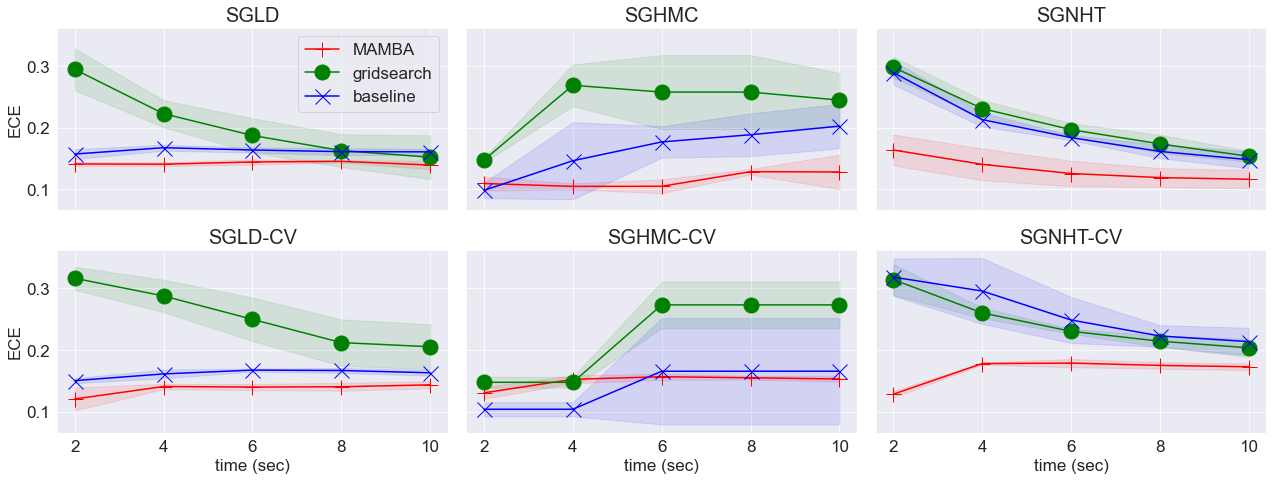

In [33]:
plt.rcParams.update({'font.size':17})

fig, ax = plt.subplots(2,3, figsize=(18,7), sharex=True, sharey=True)

plot_3_ksd_curves(ax[0,0], mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba,
                  mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch,
                  mean_ksd_curve_sgld_baseline, sd_ksd_curve_sgld_baseline,
                  "SGLD"
                 )
plot_3_ksd_curves(ax[1,0], mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba,
                  mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch,
                  mean_ksd_curve_sgldCV_baseline, sd_ksd_curve_sgldCV_baseline,
                  "SGLD-CV"
                 )
plot_3_ksd_curves(ax[0,1], mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba,
                  mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch,
                  mean_ksd_curve_sghmc_baseline, sd_ksd_curve_sghmc_baseline,
                  "SGHMC"
                 )
plot_3_ksd_curves(ax[1,1], mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba,
                  mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch,
                  mean_ksd_curve_sghmcCV_baseline, sd_ksd_curve_sghmcCV_baseline,
                  "SGHMC-CV"
                 )
plot_3_ksd_curves(ax[0,2], mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba,
                  mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch,
                  mean_ksd_curve_sgnht_baseline, sd_ksd_curve_sgnht_baseline,
                  "SGNHT"
                 )
plot_3_ksd_curves(ax[1,2], mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba,
                  mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch,
                  mean_ksd_curve_sgnhtCV_baseline, sd_ksd_curve_sgnhtCV_baseline,
                  "SGNHT-CV"
                 )

ax[0,0].legend()
ax[0,0].set_ylabel("ECE")
ax[1,0].set_ylabel("ECE")
ax[1,0].set_xlabel("time (sec)")
ax[1,1].set_xlabel("time (sec)")
ax[1,2].set_xlabel("time (sec)")

plt.tight_layout()

# plt.savefig("images/NN/all_NN_ece_curves.png")

## plot OOD figure


In [30]:
ood_entropy_samples_sgld_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgld_mamba.txt")
ood_entropy_samples_sgld_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgld_gridsearch.txt")
ood_entropy_samples_sgld_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgld_baseline.txt")

ood_entropy_samples_sgldCV_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_mamba.txt")
ood_entropy_samples_sgldCV_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_gridsearch.txt")
ood_entropy_samples_sgldCV_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_baseline.txt")

ood_entropy_samples_sghmc_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_mamba.txt")
ood_entropy_samples_sghmc_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_gridsearch.txt")
ood_entropy_samples_sghmc_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_baseline.txt")

ood_entropy_samples_sghmcCV_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_mamba.txt")
ood_entropy_samples_sghmcCV_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_gridsearch.txt")
ood_entropy_samples_sghmcCV_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_baseline.txt")

ood_entropy_samples_sgnht_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_mamba.txt")
ood_entropy_samples_sgnht_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_gridsearch.txt")
ood_entropy_samples_sgnht_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_baseline.txt")

ood_entropy_samples_sgnhtCV_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_mamba.txt")
ood_entropy_samples_sgnhtCV_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_gridsearch.txt")
ood_entropy_samples_sgnhtCV_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_baseline.txt")



In [31]:
def plot_OOD_curve(ax, ood_entropy_samples, thin_step, color,marker, label):
    y_range = np.linspace(0, 1, (len(ood_entropy_samples[::thin_step])))
    
    ax.plot(sorted(ood_entropy_samples[::thin_step]), y_range, 
             label=label, marker=marker, markersize=10)

    

def plot_3_OOD_curves(ax, ood_entropy_samples_mamba, ood_entropy_samples_gridsearch, 
                      ood_entropy_samples_baseline, title):
    thin_step = 500
    plot_OOD_curve(ax, ood_entropy_samples_mamba, thin_step, color="r", marker="+", label="MAMBA")
    plot_OOD_curve(ax, ood_entropy_samples_gridsearch, thin_step, color="g", marker="o", label="gridsearch")
    plot_OOD_curve(ax, ood_entropy_samples_baseline, thin_step, color="b", marker="x", label="baseline")
    ax.set_title(title, size=20)
    

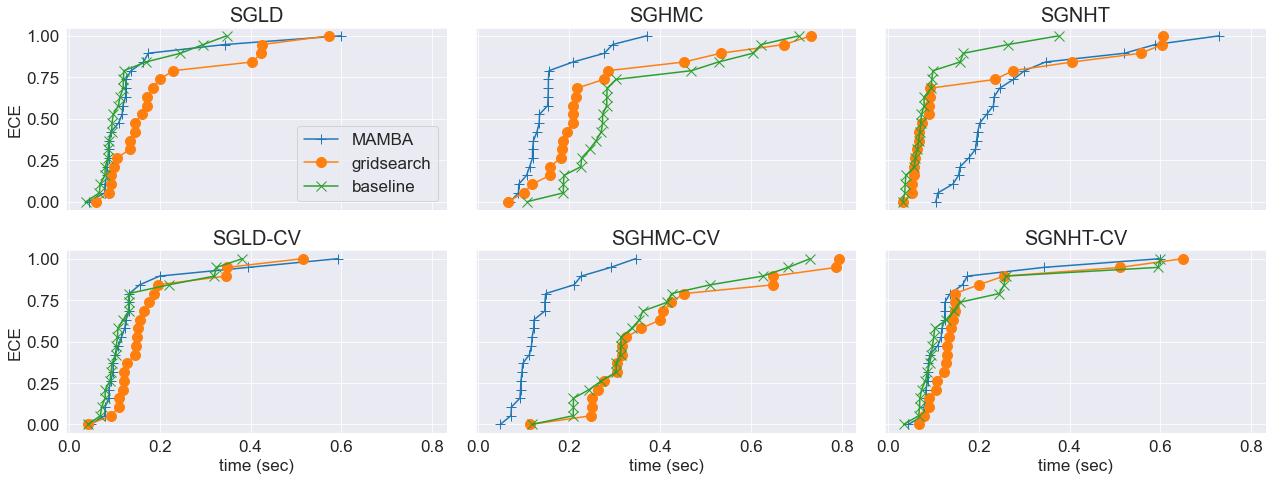

In [32]:
plt.rcParams.update({'font.size':17})

fig, ax = plt.subplots(2,3, figsize=(18,7), sharex=True, sharey=True)

plot_3_OOD_curves(ax[0,0], ood_entropy_samples_sgld_mamba,
                  ood_entropy_samples_sgld_gridsearch,
                 ood_entropy_samples_sgld_baseline, "SGLD")

plot_3_OOD_curves(ax[1,0], ood_entropy_samples_sgldCV_mamba,
                  ood_entropy_samples_sgldCV_gridsearch,
                 ood_entropy_samples_sgldCV_baseline, "SGLD-CV")

plot_3_OOD_curves(ax[0,1], ood_entropy_samples_sghmc_mamba,
                  ood_entropy_samples_sghmc_gridsearch,
                 ood_entropy_samples_sghmc_baseline, "SGHMC")

plot_3_OOD_curves(ax[1,1], ood_entropy_samples_sghmcCV_mamba,
                  ood_entropy_samples_sghmcCV_gridsearch,
                 ood_entropy_samples_sghmcCV_baseline, "SGHMC-CV")

plot_3_OOD_curves(ax[0,2], ood_entropy_samples_sgnht_mamba,
                  ood_entropy_samples_sgnht_gridsearch,
                 ood_entropy_samples_sgnht_baseline, "SGNHT")

plot_3_OOD_curves(ax[1,2], ood_entropy_samples_sgld_mamba,
                  ood_entropy_samples_sgnhtCV_gridsearch,
                 ood_entropy_samples_sgnhtCV_baseline, "SGNHT-CV")

 
ax[0,0].legend()
ax[0,0].set_ylabel("ECE")
ax[1,0].set_ylabel("ECE")
ax[1,0].set_xlabel("time (sec)")
ax[1,1].set_xlabel("time (sec)")
ax[1,2].set_xlabel("time (sec)")

plt.tight_layout()

# plt.savefig("images/NN/all_NN_OOD_curves.png")

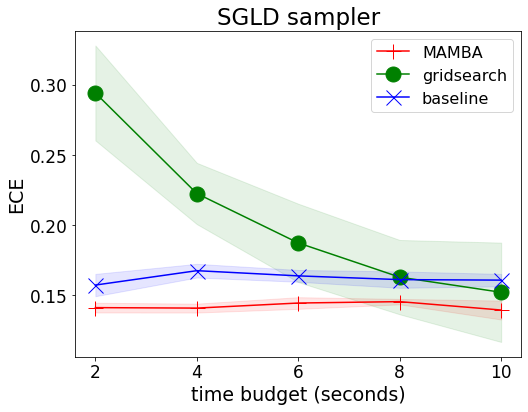

In [41]:
plt.rcParams.update({'font.size':17})

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgld_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_mamba+2*sd_ksd_curve_sgld_mamba, 
                 mean_ksd_curve_sgld_mamba-2*sd_ksd_curve_sgld_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgld_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_gridsearch+2*sd_ksd_curve_sgld_gridsearch, 
                 mean_ksd_curve_sgld_gridsearch-2*sd_ksd_curve_sgld_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sgld_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_baseline+2*sd_ksd_curve_sgld_baseline, 
                 mean_ksd_curve_sgld_baseline-2*sd_ksd_curve_sgld_baseline, alpha=0.1, color='b')

plt.title("SGLD sampler", size=23)
plt.ylabel("ECE", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/NN/sgld_ksd_curves.png")

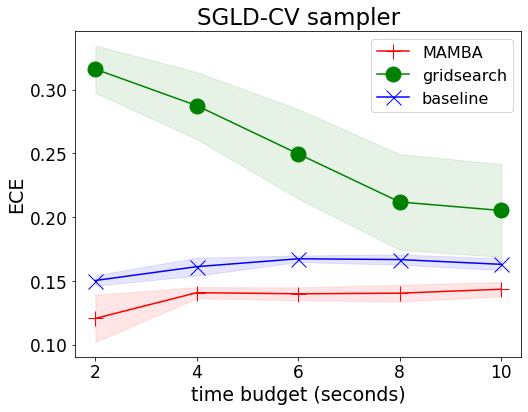

In [42]:
plt.rcParams.update({'font.size':17})

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_mamba+2*sd_ksd_curve_sgldCV_mamba, 
                 mean_ksd_curve_sgldCV_mamba-2*sd_ksd_curve_sgldCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_gridsearch+2*sd_ksd_curve_sgldCV_gridsearch, 
                 mean_ksd_curve_sgldCV_gridsearch-2*sd_ksd_curve_sgldCV_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_baseline+2*sd_ksd_curve_sgldCV_baseline, 
                 mean_ksd_curve_sgldCV_baseline-2*sd_ksd_curve_sgldCV_baseline, alpha=0.1, color='b')

plt.title("SGLD-CV sampler", size=23)
plt.ylabel("ECE", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/NN/sgldcv_ksd_curves.png")

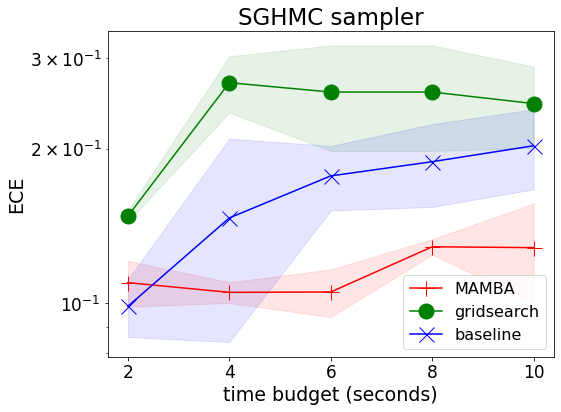

In [43]:
plt.rcParams.update({'font.size':17})

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sghmc_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_mamba+2*sd_ksd_curve_sghmc_mamba, 
                 mean_ksd_curve_sghmc_mamba-2*sd_ksd_curve_sghmc_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sghmc_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_gridsearch+2*sd_ksd_curve_sghmc_gridsearch, 
                 mean_ksd_curve_sghmc_gridsearch-2*sd_ksd_curve_sghmc_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sghmc_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_baseline+2*sd_ksd_curve_sghmc_baseline, 
                 mean_ksd_curve_sghmc_baseline-2*sd_ksd_curve_sghmc_baseline, alpha=0.1, color='b')


plt.title("SGHMC sampler", size=23)
plt.ylabel("ECE", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.yscale("log")
plt.legend(fontsize=16)
# plt.savefig("images/NN/sghmc_ksd_curves.png")

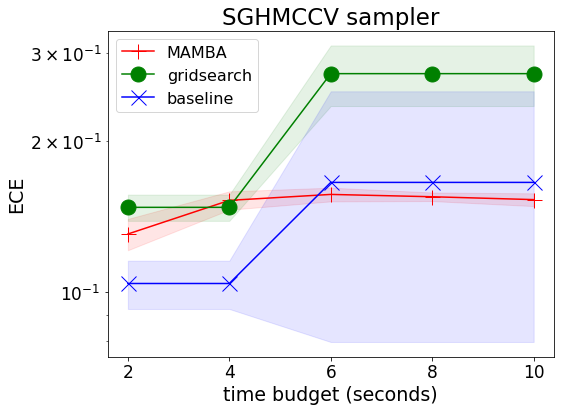

In [44]:
plt.rcParams.update({'font.size':17})

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_mamba+2*sd_ksd_curve_sghmcCV_mamba, 
                 mean_ksd_curve_sghmcCV_mamba-2*sd_ksd_curve_sghmcCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_gridsearch+2*sd_ksd_curve_sghmcCV_gridsearch, 
                 mean_ksd_curve_sghmcCV_gridsearch-2*sd_ksd_curve_sghmcCV_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_baseline+2*sd_ksd_curve_sghmcCV_baseline, 
                 mean_ksd_curve_sghmcCV_baseline-2*sd_ksd_curve_sghmcCV_baseline, alpha=0.1, color='b')

plt.title("SGHMCCV sampler", size=23)
plt.ylabel("ECE", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.yscale("log")
plt.legend(fontsize=16)
# plt.savefig("images/NN/sghmccv_ksd_curves.png")

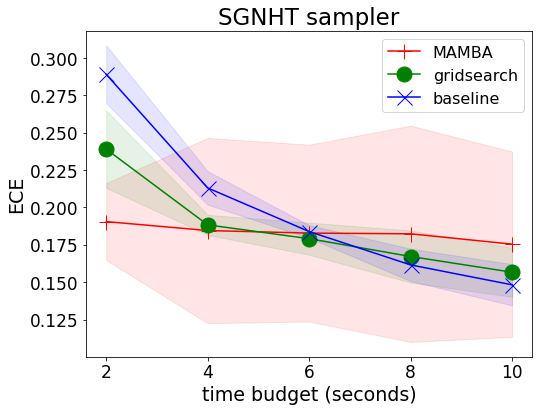

In [45]:
plt.rcParams.update({'font.size':17})

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgnht_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_mamba+2*sd_ksd_curve_sgnht_mamba, 
                 mean_ksd_curve_sgnht_mamba-2*sd_ksd_curve_sgnht_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgnht_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_gridsearch+2*sd_ksd_curve_sgnht_gridsearch, 
                 mean_ksd_curve_sgnht_gridsearch-2*sd_ksd_curve_sgnht_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sgnht_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_baseline+2*sd_ksd_curve_sgnht_baseline, 
                 mean_ksd_curve_sgnht_baseline-2*sd_ksd_curve_sgnht_baseline, alpha=0.1, color='b')


plt.title("SGNHT sampler", size=23)
plt.ylabel("ECE", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/NN/sgnht_ksd_curves.png")

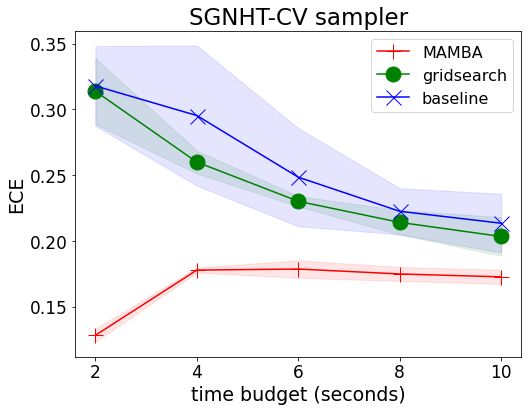

In [46]:
plt.rcParams.update({'font.size':17})

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_mamba+2*sd_ksd_curve_sgnhtCV_mamba, 
                 mean_ksd_curve_sgnhtCV_mamba-2*sd_ksd_curve_sgnhtCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_gridsearch+2*sd_ksd_curve_sgnhtCV_gridsearch, 
                 mean_ksd_curve_sgnhtCV_gridsearch-2*sd_ksd_curve_sgnhtCV_gridsearch, alpha=0.1, color='g')


plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_baseline+2*sd_ksd_curve_sgnhtCV_baseline, 
                 mean_ksd_curve_sgnhtCV_baseline-2*sd_ksd_curve_sgnhtCV_baseline, alpha=0.1, color='b')


plt.title("SGNHT-CV sampler", size=23)
plt.ylabel("ECE", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/NN/sgnhtcv_ksd_curves.png")